## Preliminary Design and Verification of a Fuel Pin


In [4]:
import numpy as np
import sympy as sp
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy.integrate import simps
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy.optimize import minimize_scalar
from scipy.special import j0

# Given data
q_l0 = 38.7 #[kW/m] Peak linear power
t_cycle = 360 #[days] Length of cycle

# Neutronic specifications
phi_0 = 6.1e15 #[n/cm^2-s] Neutron flux at peak power

# Thermo-hydraulic specifications
pitch = 8.275 #[mm] Pin pitch
T_co_in_C = 395 #[°C] Coolant inlet temperature
P_co_in = 0.1 #[MPa] Coolant inlet pressure
m_co_in = 0.049 #[kg/s] Coolant mass flow rate

# Fuel pin specifications
H_act = 850 #[mm] Fuel column height
D_fuel_out = 5.42 #[mm] Fuel pellet outer diameter
H_pellet = 7 #[mm] Fuel pellet height
TD_fuel = 11.31 #[g/cm^3] Fuel theoretical density
rho_fuel = 0.945*TD_fuel #[g/cm^3] Fuel density %TD
D_grain = 10e-6 #[m] Fuel grain diameter
r_OM = 1.957 #[O/M] Oxygen to metal ratio
D_clad_out = 6.55 #[mm] Cladding outer diameter
P_gas_0 = 0.1 #[MPa] Initial pressure of filling gas
T_gas_0 = 20 #[°C] Initial temperature of filling gas
p_asbuilt = 0.055 #[/] porosity
w_U235_0 = 0.00711 #[wt] Initial composition of U-235 in natural uranium
w_U238_0 = 1 - w_U235_0 #[wt] Initial composition of U-238 in natural uranium
w_Pu239_0 = 0.70 #[wt] Initial composition of Pu-239
w_Pu240_0 = 0.20 #[wt] Initial composition of Pu-240
w_Pu241_0 = 0.10 #[wt] Initial composition of Pu-241
w_Pu_0 = 0.29 #[wt] Initial composion of Pu in the MOX fuel
w_U_0 = 1 - w_Pu_0 #[wt] Initial composion of U in the MOX fuel
OM_ratio_0 = 1.957 #[/] Oxygen-to-metal ratio at time 0

In [5]:
# Calculation of burnup

# Input molar mass of different isotopes
M_HM = 238 #[g/mol]
M_O = 16 #[g/mol]
M_U235 = 235 #[g/mol]
M_U238 = 238 #[g/mol]
M_Pu239 = 239 #[g/mol]
M_Pu240 = 240 #[g/mol]
M_Pu241 = 241 #[g/mol]

def beta1(q_l, rho_fuel, r_fuel, H_fuel, time):
    V_fuel = np.pi* r_fuel **2 *H_fuel * 1e-9 #[m^3] Reference volume of fuel
    m_fuel = rho_fuel * V_fuel/1000 #[ton-MOx] Weight of fuel material per fuel rod
    N_HM = m_fuel / (M_HM + OM_ratio_0 * M_O)  #[ton-mol] Numero de moles de HM
    N_O = OM_ratio_0 * N_HM #[ton-mol] Numero de moles de Oxygen
    m_HM = N_HM * M_HM #[t_HM] Toneladas de Heavy Metal
    return (q_l/1e6) * (H_fuel/1000) * time / m_HM #[GWd/t_HM]

# Average burnup of the fuel rod
rho_fuel_0 = 0.945*TD_fuel*1e3 #[kg/m^3] Fuel density %TD
r_fuel_out_0 = D_fuel_out/2 #[mm] Fuel pellet outer radius
H_fuel_0 = H_act
beta_avg = beta1(q_l0, rho_fuel_0, r_fuel_out_0, H_fuel_0, t_cycle)

print(f"Burnup of fuel method1: {beta_avg:.2f} [GWd/t-HM]")

def beta2(q_l, rho_fuel, r_fuel, H_fuel, w_U235, w_U238, w_Pu239, w_Pu240, w_Pu241, w_Pu, time):
    V_fuel = np.pi* r_fuel **2 *H_fuel * 1e-9 #[m^3] Reference volume of fuel
    m_fuel = rho_fuel * V_fuel/1000 #[ton-MOx] Weight of fuel material per fuel rod
    x_U235 = (w_U235/M_U235) / ((w_U235/M_U235) + (w_U238/M_U238)) #[/] Molar fraction of U-235 in natural Uranium
    x_U238 = 1 - x_U235  #[/] Molar fraction of U-238 in natural Uranium
    x_Pu239 = (w_Pu239/M_Pu239) / ((w_Pu239/M_Pu239) + (w_Pu240/M_Pu240) + (w_Pu241/M_Pu241)) #[/] Molar fraction of Pu-239 in fresh MOX
    x_Pu240 = (w_Pu240/M_Pu240) / ((w_Pu239/M_Pu239) + (w_Pu240/M_Pu240) + (w_Pu241/M_Pu241)) #[/] Molar fraction of Pu-240 in fresh MOX
    x_Pu241 = 1 - x_Pu239 - x_Pu240  #[/] Molar fraction of Pu-241 in fresh MOX
    M_U = x_U235*M_U235 + x_U238*M_U238 #[g/gmol] Molar mass of Uranium
    M_Pu = x_Pu239*M_Pu239 + x_Pu240*M_Pu240 + x_Pu241*M_Pu241 #[g/gmol] Molar mass of Plutonium
    w_U = 1 - w_Pu #[/] Mass fraction of U in MOX
    x_Pu = (w_Pu/M_Pu) / ((w_Pu/M_Pu) + (w_U/M_U)) #[/] Molar fraction of Pu in MOX
    x_U = 1 - x_Pu #[/] Molar fraction of U in MOX
    M_HM = x_Pu*M_Pu + x_U*M_U  #[g/gmol] Molar mass of Heavy Metal
    n_HM = m_fuel / (M_HM + OM_ratio_0 * M_O)  #[ton-mol] Moles of Heavy Metal in MOX
    n_O = OM_ratio_0 * n_HM #[ton-mol] Numero de moles de Oxygen
    m_HM = n_HM * M_HM #[ton_HM] Toneladas de Heavy Metal
    return (q_l/1e6) * (H_fuel/1000) * time / m_HM #[GWd/t_HM]

# Average burnup of the fuel rod
rho_fuel_0 = 0.945*TD_fuel*1e3 #[kg/m^3] Fuel density %TD
r_fuel_out_0 = D_fuel_out/2 #[mm] Fuel pellet outer radius
H_fuel_0 = H_act
beta_avg = beta2(q_l0, rho_fuel_0, r_fuel_out_0, H_fuel_0, w_U235_0, w_U238_0, w_Pu239_0, w_Pu240_0, w_Pu241_0, w_Pu_0, t_cycle)

print(f"Burnup of fuel method2: {beta_avg:.2f} [GWd/t-HM]")

Burnup of fuel method1: 63.93 [GWd/t-HM]
Burnup of fuel method2: 63.92 [GWd/t-HM]


## Linear Power Model

Given that the information related to the power was given by nodes. It was needed to get a more suitable expression to work in the following stages of the desing. Therefore, considering that:

- The system is symmetric.
- The nodalization for the peak power factors corresponds to a range and not a single value of z. Then, the fitted curve is valid when it crosses the top of the histogram.
- The reference surface for the linear power is the outer surface of the cladding, i.e., $q_{l0}$ = 38.7 [kW/m] when $r = r_{clad,out}$.

The linear power can be expressed as:

\begin{equation}
q'_l(z) = q'_{l0} \cdot cos(\frac{\pi z}{H_{ext}})
\end{equation}

Where,

- $q_{l0}$ is the peak power at the midplane of the fuel pin (z=0).
- $H_{ext}$ is the extrapolated boundary in [m].

Extrapolated boundary (H_ext): 1.21 [m]


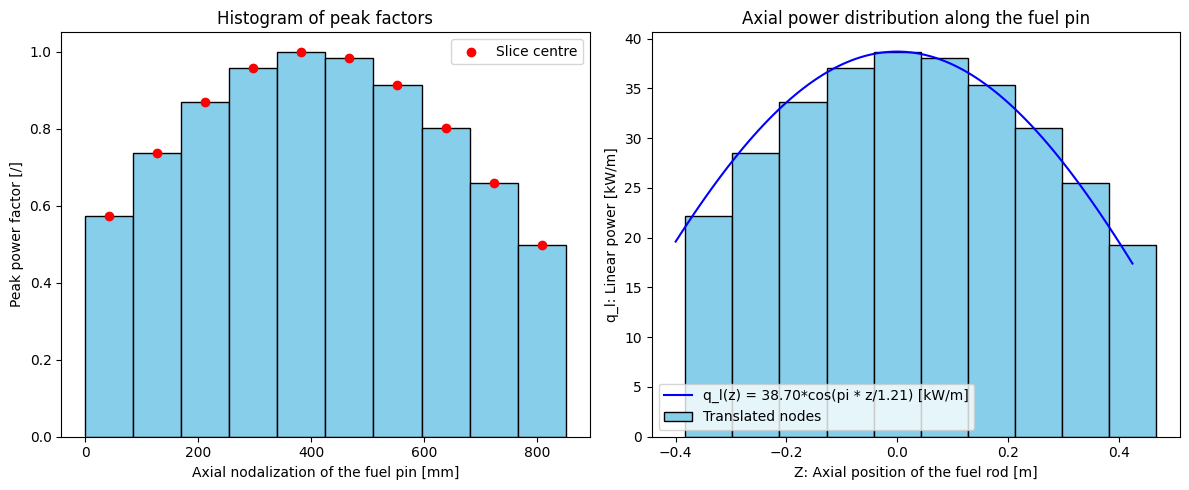

In [6]:
# Axial nodalization of fuel pin
H_nod = np.array([42.5, 127.5, 212.5, 297.5, 382.5, 467.5, 552.5, 637.5, 722.5, 807.5]) #[mm] Center of slice from bottom
H_nod_c = (H_nod - 382.5) / 1000 #[m] Corrected position of nodes from center of fuel pin
q_nod_f = np.array([0.572, 0.737, 0.868, 0.958, 1.000, 0.983, 0.912, 0.802, 0.658, 0.498]) #[/] Peak power factors

# Define a symmetric peak power function along the fuel pin
def q_l_f(z, H_ext):
    return q_l0 * np.cos(np.pi * z / H_ext)

# Extrapolated boundary
initial_guess = [1]  # Initial guess for H_ext
H_ext_opt, _ = curve_fit(q_l_f, H_nod_c, q_l0*q_nod_f, p0 = initial_guess)
H_ext = H_ext_opt[0] # [m] Optimized extrapolated boundary
print(f"Extrapolated boundary (H_ext): {H_ext:.2f} [m]")

# Plot the results
z_fit = np.linspace(-0.4, max(H_nod_c), 100)
q_fit = q_l_f(z_fit, H_ext_opt[0])

# Create a figure with two subplots arranged in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of the given peak factor power vs height from bottom
ax1.bar(H_nod, q_nod_f, width=85, color='skyblue', edgecolor='black')
ax1.scatter(H_nod, q_nod_f, label="Slice centre", color="red")
ax1.set_title('Histogram of peak factors')
ax1.set_xlabel('Axial nodalization of the fuel pin [mm]')
ax1.set_ylabel('Peak power factor [/]')
ax1.legend()

# Validation of the fitted function
ax2.bar(H_nod_c, q_l0*q_nod_f, width=0.085, label = 'Translated nodes',color='skyblue', edgecolor='black')
ax2.plot(z_fit, q_fit, label=f"q_l(z) = {q_l0:.2f}*cos(pi * z/{H_ext:.2f}) [kW/m]", color="blue")
ax2.set_title('Axial power distribution along the fuel pin')
ax2.set_xlabel("Z: Axial position of the fuel rod [m]")
ax2.set_ylabel("q_l: Linear power [kW/m]")
ax2.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Linear power function along the fuel pin
def q_l(z):
    return q_l0 * np.cos(np.pi * z / H_ext) #[kW/m]

## Mass and Energy Balance of the coolant

**(1) Total power per fuel pin:**


\begin{equation}
Q_{pin} = \int_{\frac{-H_{ext}}{2}}^{\frac{H_{ext}}{2}} q'_l(z)dz\\
Q_{pin} = \int_{\frac{-H_{ext}}{2}}^{\frac{H_{ext}}{2}} q'_{l0} \cdot cos\left(\frac{\pi z}{H_{ext}} \right)dz\\
Q_{pin} = q'_{l0}\cdot \left[sin\left(\frac{\pi z}{H_{ext}} \right) \cdot \frac{H_{ext}}{pi}\right]_{\frac{-H_{ext}}{2}} ^{\frac{H_{ext}}{2}} \\
Q_{pin} = 2\cdot q'_{l0}\cdot \frac{H_{ext}}{pi}
\end{equation}

\\

**(2) Outlet coolant temperature (iterative calculation):**

Given that the design considers a triangular pitch, the removed heat by the coolant $Q_{in}$ corresponds to the half of $Q_{pin}$. In order to simplify the calculation, the heat capacity of the coolant is considered constant along the channel at the average temperature of the coolant.

\begin{equation}
Q_{in,cool} = \frac{Q_{pin}}{2}\\
Q_{in,cool} = \dot{m}_{cool}\cdot c_{p,cool}\cdot (T_{cool,out} - T_{cool,in}) \\
T_{cool,avg} = \frac{T_{cool,in} + T_{cool,out}}{2}\\
T_{cool,out} = \frac{Q_{pin}}{2\cdot \dot{m}_{cool}\cdot c_{p,cool}(T_{cool,avg})} + T_{cool,in}
\end{equation}

In [7]:
#MASS AND ENERGY BALANCE OF THE COOLANT

# Input values
T_co_in_K = T_co_in_C + 273.15 #[K] Coolant inlet temperature

# Total power per fuel rod
Q_pin = 2 * q_l0 * H_ext / np.pi  #[kW] Total power per fuel rod
print(f'Total power per fuel rod (Q_pin): {Q_pin:.2f} [kW]')

# Outlet temperature of the coolant
Q_in = Q_pin / 2 #[kW] Total power to be removed in the channel
T_co_out_K = T_co_in_K + 50  #[K] Initial guess for the outlet temperature of the coolant
print(f'Total power to be removed by the coolant (Q_in): {Q_in:.2f} [kW]')

for _ in range(1000):
    T_co_avg_K = (T_co_in_K + T_co_out_K) / 2 #[K] Average temperature of the coolant
    cp_co_avg = 1608 - 0.7481 * T_co_avg_K + 3.929e-4 * T_co_avg_K**2 #[J/kg-K] Isobaric specific heat of coolant at average temperature
    T_co_out_new = (Q_in * 1e3) / (m_co_in * cp_co_avg) + T_co_in_K     #[K] i-th iteration for outlet temperature of coolant

    if abs(T_co_out_new - T_co_out_K) < 0.1:  # Check for convergence
        break

    T_co_out_K = T_co_out_new #[K] Update outlet temperature of coolant

T_co_out_C = T_co_out_K - 273.15 #[°C] Outlet temperature of coolant
T_co_avg_C = T_co_avg_K - 273.15 #[°C] Average temperature of the coolant

print(f"Inlet temperature of the coolant (T_co_out): {T_co_in_C:.2f} [°C]")
print(f"Outlet temperature of coolant (T_co_out): {T_co_out_C:.2f} [°C]")
print(f"Average temperature of coolant (T_co_avg): {T_co_avg_C:.2f} [°C]")
print(f'Cp of coolant at average temperature: {cp_co_avg:.2f} [J/kg-K]')

Total power per fuel rod (Q_pin): 29.78 [kW]
Total power to be removed by the coolant (Q_in): 14.89 [kW]
Inlet temperature of the coolant (T_co_out): 395.00 [°C]
Outlet temperature of coolant (T_co_out): 635.72 [°C]
Average temperature of coolant (T_co_avg): 515.36 [°C]
Cp of coolant at average temperature: 1262.40 [J/kg-K]


## Heat Transfer Coefficient of the Coolant

In order to calculate the heat transfer coefficient of the coolant. It is needed to consider the geometry, the regime of the fluid and its physical properties. The evaluation of all these parameters is done by the following adimensional numbers.

\begin{equation}
Re = \frac{\rho v D_h}{\mu}\\
Pr = \frac{\mu c_p}{k}\\
Pe = Re \cdot Pr\\
Nu = 7 + 0.025 Pe^{0.8}\\
h_{cool} = \frac{Nu\cdot k}{D_h}\\
D_h = \frac{4A_p}{P_w}
\end{equation}

In [8]:
  # CALCULATION OF HEAT TRANSFER COEFFICIENT OF THE COOLANT

# Input values
T_co_avg_F = (T_co_avg_C * 9/5) + 32 #[°F] Average temperature of the coolant

# Coolant properties at average temperature
rho_co_avg = 954.1579 + T_co_avg_F * (T_co_avg_F * (T_co_avg_F * 0.9667e-9 - 0.46e-5) - 0.1273534) #[kg/m^3] Density of the coolant
mu_co_avg = np.exp(813.9 / T_co_avg_K - 2.530) #[mPa-s] Dynamic viscosity of coolant
k_co_avg = 110 - 0.0648 * T_co_avg_K + 1.16e-5 * T_co_avg_K**2 #[W/m-K] Thermal conductivity of coolant
print(f"Density of the coolant at average temperature (rho_co_avg): {rho_co_avg:.2f} [kg/m^3]")
print(f"Dynamic viscosity of coolant at average temperature (mu_co_avg): {mu_co_avg:.2f} [mPa-s]")
print(f"Thermal conductivity of coolant at average temperature (k_co_avg): {k_co_avg:.2f} [W/m-K]")

# Geometry of channel
A_channel = 3**(1/2) / 4 * pitch**2 - np.pi * D_clad_out**2 / 8 #[mm^2] Area channel
P_w = np.pi * D_clad_out / 2 #[mm] Wet perimeter
D_h = 4 * A_channel / P_w / 1000 #[m] Hydraulic diameter of channel

# Velocity of coolant through the channel
volflow_co_avg = m_co_in / rho_co_avg #[m^3/s] Volumetric flow of coolant
v_co_avg = volflow_co_avg / (A_channel / 1e6) #[m/s] Average coolant velocity
print(f"Average coolant velocity (v_co_avg): {v_co_avg:.2f} [m/s]")

# Calculation of adimensional numbers
Re_co = rho_co_avg * v_co_avg * D_h / (mu_co_avg / 1000) #[/] Reynolds number
Pr_co = (mu_co_avg * 1e-3) * cp_co_avg / k_co_avg #[/] Prandtl number
Pe_co = Re_co * Pr_co #[/] Peclet number
Nu_co = 7 + 0.025 * Pe_co**0.8 #[/] Nusselt number

# Convection heat transfer coefficient
h_co = Nu_co * k_co_avg / D_h #[W/m^2-K]

print(f'A_p {A_channel:.2f} [mm^2]')
print(f'P_w {P_w:.2f} [mm]')
print(f'Hydraulic diameter of channel {D_h*1000:.2f} [mm]')
print(f'volumetric flow {volflow_co_avg} [m^3/s]')
print(f'Heat transfer coeficient of coolant: {h_co:.2f} [W/m^2-K]')

Density of the coolant at average temperature (rho_co_avg): 828.56 [kg/m^3]
Dynamic viscosity of coolant at average temperature (mu_co_avg): 0.22 [mPa-s]
Thermal conductivity of coolant at average temperature (k_co_avg): 66.12 [W/m-K]
Average coolant velocity (v_co_avg): 4.62 [m/s]
A_p 12.80 [mm^2]
P_w 10.29 [mm]
Hydraulic diameter of channel 4.98 [mm]
volumetric flow 5.913860567958722e-05 [m^3/s]
Heat transfer coeficient of coolant: 130123.84 [W/m^2-K]


## Radial Temperature Profile at Midplane

The surface temperature of the cladding at the midplane is calculated using the convection heat transfer equation at z=0, where the temperature of the coolant at this point is equal to its average temperature.

\begin{equation}
T_{clad,out} = \frac{q_{l0}}{P_w\cdot h_{cool}} + T_{cool,avg}\\
\end{equation}

Furthermore, as the linear power function is given at the outer surface of the cladding, it is needed a relation that shows its variation with the radius. This can be found by doing and energy balance in an infinitesimal plane at radius r. This allows to find a general expression for $q''(r,z)$.

\begin{equation}
Q_{in} = Q_{out}\\
q''_{in}(r_{in})\cdot A_{in} = q''_{out}(r_{out}) \cdot A_{out} = \frac{q'_{l0} \cdot cos(\frac{\pi z}{H_{ext}})}{P_w}\cdot A_{clad,out}\\
q''_{in}(r_{in})\cdot 2\pi r_{in}H = \frac{q'_{l0} \cdot cos(\frac{\pi z}{H_{ext}})}{P_w}\cdot P_wH\\
q''(r,z) = \frac{q'_{l0}}{2\pi r}\cdot cos(\frac{\pi z}{H_{ext}})
\end{equation}

For z = 0, we get the needed expression.

\begin{equation}
q''(r) = \frac{q'_{l0}}{2\pi r}
\end{equation}

By using the conductivity equation in the radial direction, and considering that the conductivity variation is very small. Then the radial temperature profile is,

\begin{equation}
q''(r) = -k dT/dr\\
\frac{q'_{l0}}{2\pi r} = - dT/dr\\
T(r) = - \frac{q'_{l0}}{2\pi k_{clad}}\cdot ln(r) + C
\end{equation}

Where the constant is evaluated at $T(r_{clad,out}) = T_{clad,out}$

Outer cladding temperature at the midplane: 529.81 [°C]
Initial guess for the average thermal conductivity of cladding at the midplane: 20.11 [W/m-K]
Average thermal conductivity of the gap at the midplane: 20.37 [W/m-K]
Inner cladding temperature at the midplane: 574.50 [°C]


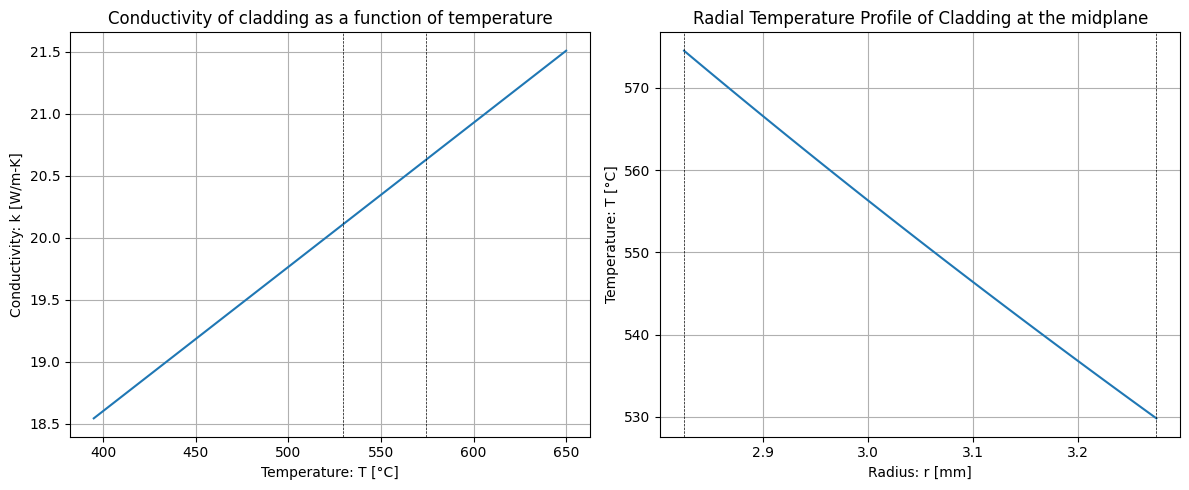

In [9]:
# RADIAL TEMPERATURE PROFILE OF CLADDING AT MIDPLANE

# Cladding thickness guess value
t_clad_i0 = 0.45 #[mm] Initial guess of cladding thickness

# Geometry of cladding
r_clad_out = D_clad_out/2 #[mm] External radius of cladding
r_clad_in = r_clad_out - t_clad_i0 #[mm] Internal radius of cladding

# Outer cladding temperature
T_co_avg0 = (T_co_in_K + T_co_out_K) / 2 #[K] Average temperature of coolant along the channel
T_clad_out0_K = q_l0*1e3 / (2 * np.pi * (r_clad_out/1000) * h_co) + T_co_avg0 #[K] Outer cladding temperature
T_clad_out0 = T_clad_out0_K - 273.15 #[°C]
print(f'Outer cladding temperature at the midplane: {T_clad_out0:.2f} [°C]')

def k_clad(T_clad):
  return 13.95 + 0.01163 * T_clad #[W/m-K] Thermal conductivity of cladding. Temparature in [°C]

# Radial temperature profile of the cladding at the midplane
def T_clad_r0(r_clad, k_clad):
    C = T_clad_out0 + (q_l0 * 1e3 * np.log(r_clad_out)) / (2 * np.pi * k_clad)
    return -(q_l0 * 1e3 * np.log(r_clad)) / (2 * np.pi * k_clad) + C

# Iterative correction for the average conductivitiy of the cladding at the midplane
k_clad_out_0 = k_clad(T_clad_out0) #[W/m-K]
k_clad_avg_0 = (k_clad_out_0 + k_clad_out_0)/2 #[W/m-K]  # Initial guess
iteration = 0
eps = 1e-4  # Convergence tolerance
max_iterations = 100  # To avoid infinite loops
print(f'Initial guess for the average thermal conductivity of cladding at the midplane: {k_clad_avg_0:.2f} [W/m-K]')

while True:
    iteration += 1
    T_clad_in_0 = T_clad_r0(r_clad_in, k_clad_avg_0)
    k_clad_in_0 = k_clad(T_clad_in_0)
    k_clad_avg_0_new = (k_clad_in_0 + k_clad_out_0) / 2

    if abs(k_clad_avg_0_new - k_clad_avg_0) < eps or iteration >= max_iterations:
        k_clad_avg_0 = k_clad_avg_0_new
        break

    k_clad_avg_0 = k_clad_avg_0_new

if iteration >= max_iterations:
    print("Warning: Maximum iterations reached without convergence")
print(f'Average thermal conductivity of the gap at the midplane: {k_clad_avg_0:.2f} [W/m-K]')

# Inner cladding temperature at midplane
T_clad_in0 = T_clad_r0(r_clad_in, k_clad_avg_0)
print(f'Inner cladding temperature at the midplane: {T_clad_in0:.2f} [°C]')

# Define range of values for graph cladding conductivity vs temperature
T_clad_values = np.linspace(T_co_in_C, 650, 100)
k_clad_values = k_clad(T_clad_values) #[W/m-K] Thermal conductivity of cladding

# Create a figure with two subplots arranged in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(T_clad_values, k_clad_values)
ax1.set_title('Conductivity of cladding as a function of temperature')
ax1.set_ylabel('Conductivity: k [W/m-K]')
ax1.set_xlabel('Temperature: T [°C]')
ax1.axvline(T_clad_in0, color = 'black', linewidth = 0.5, ls = '--')
ax1.axvline(T_clad_out0, color = 'black', linewidth = 0.5, ls = '--')
ax1.grid()

# Define range of values for graph cladding temperature vs radius
r_clad_values = np.linspace(r_clad_in, r_clad_out, 100)  #values along cladding thickness
T_clad_values = T_clad_r0(r_clad_values, k_clad_avg_0)

# Plot the results
ax2.plot(r_clad_values, T_clad_values)
ax2.set_title('Radial Temperature Profile of Cladding at the midplane')
ax2.set_xlabel('Radius: r [mm]')
ax2.set_ylabel('Temperature: T [°C]')
ax2.axvline(r_clad_out, color='black',linewidth=0.5, ls='--')
ax2.axvline(r_clad_in, color='black',linewidth=0.5, ls='--')
ax2.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Outer gap temperature at the midplane: 574.50 [°C]
Initial guess for the average thermal conductivity of He at the midplane: 0.33 [W/m-K]
Average thermal conductivity of the gap at the midplane: 0.41 [W/m-K]
Inner gap temperature at the midplane: 1193.99 [°C]


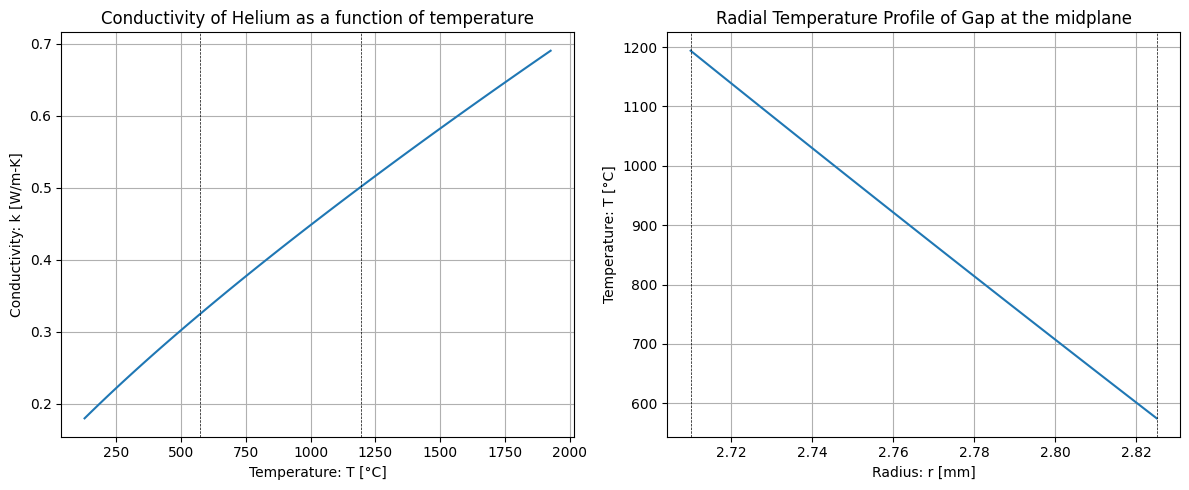

In [10]:
# RADIAL TEMPERATURE PROFILE OF GAP AT MIDPLANE

# Define constants
T_gap_out0_C = T_clad_in0 #[°C] Outer temperature of the gap at cladding side
r_gap_out = r_clad_in #[mm] Outer radius of the gap
r_gap_in = D_fuel_out/2 #[mm] Inner radius of the gap
T_gap_out0_K = T_gap_out0_C + 273.15 #[K] Outer temperature of gap
print(f'Outer gap temperature at the midplane: {T_gap_out0_C:.2f} [°C]')

def k_He(T_gap):
  return 15.8e-4 * T_gap**0.79 #[W/m-K] Average thermal conductivity of filling gas at midplane. T_gap in [K]

# Radial temperature profile of the gap at the midplane
def T_gap_K_0(r_gap, k_He):
    C = T_gap_out0_K + (q_l0 * 1e3 * np.log(r_gap_out)) / (2 * np.pi * k_He)
    return -(q_l0 * 1e3 * np.log(r_gap)) / (2 * np.pi * k_He) + C

# Iterative correction for the average conductivitiy of the gap at the midplane
k_He_out_0 = k_He(T_gap_out0_K) #[W/m-K]
k_He_avg_0 = (k_He_out_0 + k_He_out_0)/2 #[W/m-K]  # Initial guess
iteration = 0
eps = 1e-4  # Convergence tolerance
max_iterations = 100  # To avoid infinite loops
print(f'Initial guess for the average thermal conductivity of He at the midplane: {k_He_avg_0:.2f} [W/m-K]')

while True:
    iteration += 1
    T_gap_K_in_0 = T_gap_K_0(r_gap_in, k_He_avg_0)
    k_He_in_0 = k_He(T_gap_K_in_0)
    k_He_avg_0_new = (k_He_in_0 + k_He_out_0) / 2

    if abs(k_He_avg_0_new - k_He_avg_0) < eps or iteration >= max_iterations:
        k_He_avg_0 = k_He_avg_0_new
        break

    k_He_avg_0 = k_He_avg_0_new

if iteration >= max_iterations:
    print("Warning: Maximum iterations reached without convergence")
print(f'Average thermal conductivity of the gap at the midplane: {k_He_avg_0:.2f} [W/m-K]')

# Inner cladding temperature at midplane
T_gap_in0_C = T_gap_K_0(r_gap_in, k_He_avg_0) - 273.15 #[°C]
print(f'Inner gap temperature at the midplane: {T_gap_in0_C:.2f} [°C]')

# Define range of values for graph gap conductivity vs temperature
T_gap_values = np.linspace(400, 2200, 100) #[K]
k_gap_values = k_He(T_gap_values) #[W/m-K] Thermal conductivity of filling gas at different temperatures

# Create a figure with two subplots arranged in 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(T_gap_values-273.15, k_gap_values)
ax1.set_title('Conductivity of Helium as a function of temperature')
ax1.set_ylabel('Conductivity: k [W/m-K]')
ax1.set_xlabel('Temperature: T [°C]')
ax1.axvline(T_gap_in0_C, color = 'black', linewidth = 0.5, ls = '--')
ax1.axvline(T_gap_out0_C, color = 'black', linewidth = 0.5, ls = '--')
ax1.grid()

# Define range of values for graph gap temperature vs radius
r_gap_values = np.linspace(r_gap_in, r_gap_out, 100)  #values along cladding thickness
T_gap_C_values = T_gap_K_0(r_gap_values, k_He_avg_0) - 273.15 #[°C]

# Plot the results
ax2.plot(r_gap_values, T_gap_C_values)
ax2.set_title('Radial Temperature Profile of Gap at the midplane')
ax2.set_xlabel('Radius: r [mm]')
ax2.set_ylabel('Temperature: T [°C]')
ax2.axvline(r_gap_out, color='black',linewidth=0.5, ls='--')
ax2.axvline(r_gap_in, color='black',linewidth=0.5, ls='--')
ax2.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Axial Temperature Profile

To determine the axial temperature profile of the cladding, gap and fuel. We proceed in the same way that before by calculating the outer temperature of the cladding given by the energy balance in the surface, for all the length of the rod, and then calculating the radial temperature profile inwards.

By considering an infinitesimal disk around the fuel rod, we can determine the temperature of the coolant at the inlet and outlet of the disk by adding the heat that receives that portion of fluid.

\begin{equation}
dQ_{clad,out} = dQ_{cool,in}\\
dQ_{clad,out}(z) = q''(r_{clad,out},z)\cdot dA_{clad,out} = \frac{q'_{l0}}{2\pi r_{clad,out}}\cdot cos(\frac{\pi z}{H_{ext}}) P_Wdz\\
dQ_{clad,out}(z) = {q'_{l0}}\cdot cos(\frac{\pi z}{H_{ext}})dz\\
dQ_{cool,in} = \dot{m}_{cool}\cdot c_{p,cool}\cdot dT_{cool}\\
{q'_{l0}}\cdot cos(\frac{\pi z}{H_{ext}})dz = \dot{m}_{cool}\cdot c_{p,cool}\cdot dT_{cool}\\
T_{cool}(z) = \frac{q'_{l0}}{\dot{m}_{cool}\cdot c_{p,cool}}\cdot sin(\frac{\pi z}{H_{ext}})\cdot \frac{H_{ext}}{\pi} + C
\end{equation}

Where C can be determined by evaluating $T_{cool}(-H_{ext}/2) = T_{cool,in}$. Here it was assumed that the coolant inlet temperature is controlled in an external equipment, therefore, the inlet temperature wouldn't be suitable if is stablished in $z=-H_{act}/2$ because of the energy absorbed by the coolant before reaching this point. Then the outer temperature of the cladding is just,

\begin{equation}
T_{clad,out}(z) = \frac{{q'_{l0}}}{P_w\cdot h_{cool}}\cdot cos\left(\frac{\pi z}{H_{ext}}\right) + T_{cool}(z) \\
\end{equation}

Now, considering that we know the outer temperature of the cladding at any axial position, the axial profile of the inner radius can be calculated in the same way as it was calculated the radial temperature profile before, i.e., we first calculate the temperture at a fixed z, and then is calculated inwards.

The code considers a function of $T(r,z)$ for the cladding, gap and fuel. However, this script is only to facilitate the calculation, where, first z is fixed, determining the boundary condition for the radial profile, and then calculating the radial temperature. The procedure is at follows,

\begin{equation}
T(r,z_{cte}) = - \frac{q'_{l0}\cdot cos\left(\frac{\pi z_{cte}}{H_{ext}}\right)}{2\pi k}\cdot ln(r) + C\\
C = T(r_{B.C.},z_{cte}) + \frac{q'_{l0}\cdot cos\left(\frac{\pi z_{cte}}{H_{ext}}\right)}{2\pi k}\cdot ln(r_{B.C.})\\
T(r,z_{cte}) =  T(r_{B.C.},z_{cte}) + \frac{q'_{l0}\cdot cos\left(\frac{\pi z_{cte}}{H_{ext}}\right)}{2\pi k}\cdot ln(r_{B.C.}/r)
\end{equation}

Maximum temperature at external wall of cladding: 636.62 [°C] at H = 558.48 (out of the active section) [mm]
Maximum temperature at internal wall of cladding: 649.69 [°C] at H = 427.59 (out of the active section) [mm]
Maximum temperature at the midwall of the cladding: 641.07 [°C] at H = 492.09 (out of the active section) [mm]
Maximum temperature at external wall of fuel (estimation): 1205.04 [°C] at H = 67.51 (out of the active section) [mm]
Temperature of coolant at midplane: 515.38 [°C]
Outer wall temperature of cladding at midplane: 529.83 [°C]
Inner wall temperature of cladding at midplane: 574.96 [°C]


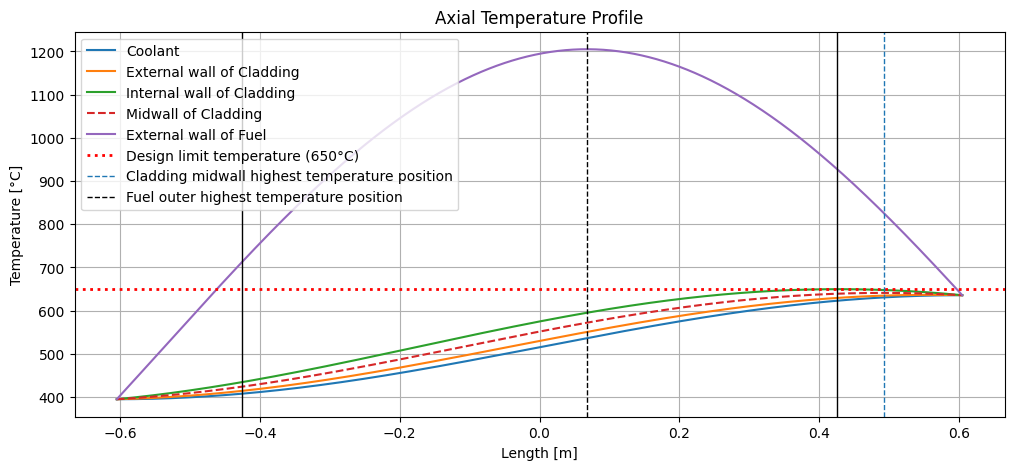

In [11]:
# AXIAL TEMPERATURE PROFILE OF COOLANT, CLADDING AND GAP

# Design limit for the cladding
T_clad_limit = 650 #[°C] Maximum temperature of the cladding

# Define radial positions
r_clad_mw = (r_clad_in + r_clad_out)/2 #[mm] Midwall position of the cladding
r_gap_in = D_fuel_out/2 #[mm] Inner radius of the gap

# Axial temperature profile of the coolant
def T_co_z(z):
    C = T_co_in_C - q_l0/2 * 1e3 * np.sin(- np.pi / 2) * H_ext / (m_co_in * cp_co_avg * np.pi)
    return q_l0/2 * 1e3 * np.sin(np.pi * z / H_ext) * H_ext / (m_co_in * cp_co_avg * np.pi) + C #[°C] The heat transferred is the half of one pin

# Axial temperature profile of the outer wall of the cladding
def T_clad_out_z(z):
    return q_l0*1e3 * np.cos(np.pi * z / H_ext) / (2 * np.pi * (r_clad_out/1000) * h_co) + T_co_z(z)

# Temperature profile of the cladding as a function of radial and axial position
def T_clad(r_clad, k_clad, z):
    return T_clad_out_z(z) + q_l0*1e3 * np.cos(np.pi * z / H_ext) * np.log(r_clad_out/r_clad)  / (2*np.pi * k_clad)

# Define average conductivity of the cladding
T_clad_out_avg = (T_clad_out_z(-H_act/2) + T_clad_out_z(H_act/2))/2
k_clad_out_avg = k_clad(T_clad_out_avg) #[W/m-K]
k_clad_avg = (k_clad_out_avg + k_clad_avg_0)/2 #[W/m-K]

# Temperature profile of the gap as a function of radius and axial coordinate
def T_gap_K(r_gap, k_He, z):
    return T_clad(r_clad_in, k_clad_avg, z) + 273.15 + q_l0*1e3 * np.cos(np.pi * z / H_ext) * np.log(r_clad_in/r_gap) / (2 * np.pi * k_He)

# Define the range of z_clad values
z_values = np.linspace(-H_ext/2, H_ext/2, 1000)  #[m]

# Calculate the axial temperature profiles
T_co_values = T_co_z(z_values)
T_clad_out_values = T_clad_out_z(z_values)
T_clad_in_values = T_clad(r_clad_in, k_clad_avg, z_values)
T_clad_mw_values = T_clad(r_clad_mw, k_clad_avg, z_values)
T_gap_in_values = T_gap_K(r_gap_in, k_He_avg_0, z_values) - 273.15 #[°C] Initial calculation with k_He_avg_0 to estimate hottest point of the fuel surface

# Calculate the maximum temperature
T_clad_out_res = minimize_scalar(lambda z: - T_clad_out_z(z), bounds=(-H_ext/2, H_ext/2), method='bounded')
T_clad_out_max = T_clad_out_z(T_clad_out_res.x)
T_clad_in_res = minimize_scalar(lambda z: - T_clad(r_clad_in, k_clad_avg, z), bounds=(-H_ext/2, H_ext/2), method='bounded')
T_clad_in_max = T_clad(r_clad_in, k_clad_avg, T_clad_in_res.x)
T_clad_mw_res = minimize_scalar(lambda z: - T_clad(r_clad_mw, k_clad_avg, z), bounds=(-H_ext/2, H_ext/2), method='bounded')
T_clad_mw_max = T_clad(r_clad_mw, k_clad_avg, T_clad_mw_res.x)
T_gap_in_res = minimize_scalar(lambda z: - T_gap_K(r_gap_in, k_He_avg_0, z), bounds=(-H_ext/2, H_ext/2), method='bounded')
T_gap_in_max = T_gap_K(r_gap_in, k_He_avg_0, T_gap_in_res.x) - 273.15

# Print results the maximum temperature
print(f'Maximum temperature at external wall of cladding: {T_clad_out_max:.2f} [°C] at H = {T_clad_out_res.x*1000:.2f} (out of the active section) [mm]')
print(f'Maximum temperature at internal wall of cladding: {T_clad_in_max:.2f} [°C] at H = {T_clad_in_res.x*1000:.2f} (out of the active section) [mm]')
print(f'Maximum temperature at the midwall of the cladding: {T_clad_mw_max:.2f} [°C] at H = {T_clad_mw_res.x*1000:.2f} (out of the active section) [mm]')
print(f'Maximum temperature at external wall of fuel (estimation): {T_gap_in_max:.2f} [°C] at H = {T_gap_in_res.x*1000:.2f} (out of the active section) [mm]')
print(f'Temperature of coolant at midplane: {T_co_z(0):.2f} [°C]')
print(f'Outer wall temperature of cladding at midplane: {T_clad_out_z(0):.2f} [°C]')
print(f'Inner wall temperature of cladding at midplane: {T_clad(r_clad_in, k_clad_avg, 0):.2f} [°C]')

# Plot the results
plt.figure(figsize=(12, 5))   # Set the figure size
plt.plot(z_values, T_co_values, label = 'Coolant')  # r_fuel is already in mm
plt.plot(z_values, T_clad_out_values, label = 'External wall of Cladding')  # r_fuel is already in mm
plt.plot(z_values, T_clad_in_values, label = 'Internal wall of Cladding')  # r_fuel is already in mm
plt.plot(z_values, T_clad_mw_values, label = 'Midwall of Cladding', ls = '--')  # r_fuel is already in mm
plt.plot(z_values, T_gap_in_values, label = 'External wall of Fuel')  # r_fuel is already in mm
plt.title('Axial Temperature Profile')
plt.xlabel('Length [m]')
plt.ylabel('Temperature [°C]')
plt.axhline(T_clad_limit, color = 'red', linestyle = ':', linewidth = 2, label ='Design limit temperature (650°C)')
plt.axvline(T_clad_mw_res.x, linestyle = '--', linewidth = 1.0, label ='Cladding midwall highest temperature position')
plt.axvline(T_gap_in_res.x, color = 'black', linestyle = '--', linewidth = 1.0, label ='Fuel outer highest temperature position')
plt.axvline(-H_act/2/1000, color='black',linewidth=1.0, ls='-')
plt.axvline(H_act/2/1000, color='black',linewidth=1.0, ls='-')
plt.legend()
plt.grid()
plt.show()

## Radial Temperature Profile at the Hottest Point of the fuel

The radial temperature profile is calculated with the following procedure:

1. Fixed z-coordinate for the highest outer fuel temperature at $z=67.51$.
2. Calculation of the outer cladding temperature $T_{clad,out}(z=67.51)$.
3. Calculation of the inner cladding temperature $T(r=r_{clad,in},z=67.51)$ considering $T_{clad,out}(z=67.51)$ as the boundary condition.
4. Calculation of the outer fuel temperature $T(r=r_{fuel,out},z=67.51)$ considering $T(r=r_{clad,in},z=67.51)$ as the boundary condition.

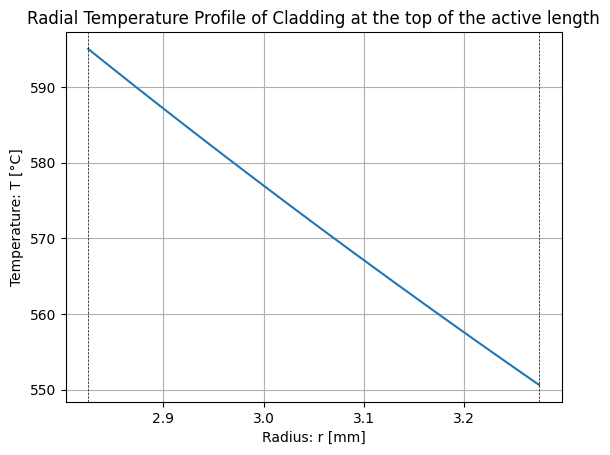

In [12]:
# RADIAL TEMPERATURE PROFILE OF CLADDING AT THE HOTTEST POINT

# Define constants
z_hot = T_gap_in_res.x #[m] Axial coordinate of the hottest point
T_clad_hot_values = T_clad(r_clad_values, k_clad_avg, z_hot)

# Plot the results
plt.plot(r_clad_values, T_clad_hot_values)
plt.title('Radial Temperature Profile of Cladding at the top of the active length')
plt.xlabel('Radius: r [mm]')
plt.ylabel('Temperature: T [°C]')
plt.axvline(r_clad_out, color='black',linewidth=0.5, ls='--')
plt.axvline(r_clad_in, color='black',linewidth=0.5, ls='--')
plt.grid()
plt.show()

Outer gap temperature at the hottest axial position for the fuel: 595.06 [°C]
Initial guess for the average thermal conductivity of He at the midplane: 0.33 [W/m-K]
Average thermal conductivity of the gap at the midplane: 0.42 [W/m-K]
Inner gap temperature at the hottest axial position: 1199.42 [°C]


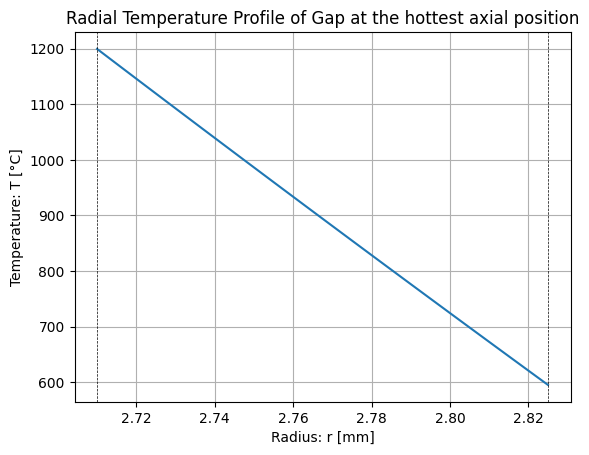

In [13]:
# RADIAL TEMPERATURE PROFILE OF GAP AT THE HOTTEST POINT

# Define constants
z_hot = T_gap_in_res.x #[m] Axial coordinate of the hottest point
T_gap_out_hot_C = T_clad(r_clad_in, k_clad_avg, z_hot) #[°C] Outer temperature of the gap at cladding side
T_gap_out_hot_K = T_gap_out_hot_C + 273.15 #[K] Outer temperature of gap
print(f'Outer gap temperature at the hottest axial position for the fuel: {T_gap_out_hot_C:.2f} [°C]')

# Temperature profile of the gap as a function of radius and axial coordinate
def T_gap_K(r_gap, k_He, z):
    C = (T_clad(r_clad_in, k_clad_avg, z) + 273.15) + q_l0*1e3 * np.cos(np.pi * z / H_ext) * np.log(r_gap_out) / (2 * np.pi * k_He)
    return -(q_l0*1e3 *np.cos(np.pi * z / H_ext) * np.log(r_gap)) / (2 * np.pi * k_He) + C

# Iterative correction for the average conductivitiy of the gap at the hottest point
k_He_out_hot = k_He(T_gap_out_hot_K) #[W/m-K]
k_He_avg_hot = (k_He_out_hot + k_He_out_hot)/2 #[W/m-K]  # Initial guess
iteration = 0
eps = 1e-4  # Convergence tolerance
max_iterations = 100  # To avoid infinite loops
print(f'Initial guess for the average thermal conductivity of He at the midplane: {k_He_avg_hot:.2f} [W/m-K]')

while True:
    iteration += 1
    T_gap_K_in_hot = T_gap_K(r_gap_in, k_He_avg_hot, z_hot)
    k_He_in_hot = k_He(T_gap_K_in_hot)
    k_He_avg_hot_new = (k_He_in_hot + k_He_out_hot) / 2

    if abs(k_He_avg_hot_new - k_He_avg_hot) < eps or iteration >= max_iterations:
        k_He_avg_hot = k_He_avg_hot_new
        break

    k_He_avg_hot = k_He_avg_hot_new # This value can be used to manually iterate over the axial profile of the gap

if iteration >= max_iterations:
    print("Warning: Maximum iterations reached without convergence")
print(f'Average thermal conductivity of the gap at the midplane: {k_He_avg_hot:.2f} [W/m-K]')

# Inner cladding temperature at the top of the active length
T_gap_in_hot_C = T_gap_K(r_gap_in,  k_He_avg_hot, z_hot) - 273.15 #[°C]
print(f'Inner gap temperature at the hottest axial position: {T_gap_in_hot_C:.2f} [°C]')

# Define range of values for graph gap temperature vs radius
T_gap_hot_values = T_gap_K(r_gap_values, k_He_avg_hot, z_hot) - 273.15 #[°C]

# Plot the results
plt.plot(r_gap_values, T_gap_hot_values)
plt.title('Radial Temperature Profile of Gap at the hottest axial position')
plt.xlabel('Radius: r [mm]')
plt.ylabel('Temperature: T [°C]')
plt.axvline(r_gap_out, color='black',linewidth=0.5, ls='--')
plt.axvline(r_gap_in, color='black',linewidth=0.5, ls='--')
plt.grid()
plt.show()

## Radial Temperature of the Fuel

The thermal conductivity of the fuel changes with change in temperature with the following relation:

\begin{equation}
\int_{T_{fo}}^{T(r)}k(T)dT = \frac{q'}{4π}*(1-(\frac{r}{r_{fo}})^2)
\end{equation}

Using the relations provided in the pdf, k(T) is given by:
\begin{equation}
k(T) = 1.755+(k_0-1.755)*exp(\frac{β}{128.15})
\end{equation}

\begin{equation}
k_0(T) = (\frac{1}{A+B*T(K)} + \frac{D}{T^2(K)}*exp(\frac{E}{T(K))}))*(1-p)^2
\end{equation}

\begin{equation}
A=0.01926+1.06*10^{-6}*x +2.63*10^{-8}
\end{equation}

\begin{equation}
B=2.39*10^{-4} + 1.37*10^{-13}
\end{equation}

\begin{equation}
D=5.27*10^{9}
\end{equation}

\begin{equation}
E=17109.5
\end{equation}

The term x used in A is the deviation	from	stoichiometry and is calculated as:
\begin{equation}
x=2-O/M
\end{equation}

Takin all of the previous equations into account, and solving the integral we get an equation that cannot be solved analytically, but only numerically.

\begin{equation}
1.755(T(r)-T_1)(1-e^x)+(1-p)^{2.5}(\frac{ln(B*T(r)+A)}{B}-\frac{ln(B*T_{fo})+A)}{B}+D*\frac{e^{-E/T(r)}-e^{-E/T_{fo}}}{E}) = \frac{q'}{4π}(1-(\frac{r}{r_{fo}})^2)
\end{equation}

Outer fuel temperature at the hottest axial position: 1199.42 [°C]
Initial guess for the average thermal conductivity at the hottest axial position: 2.12 [W/m-K]
Average thermal conductivity at the hottest axial position: 2.20 [W/m-K]
Maximum temperature at fuel: 2575.14 [°C]


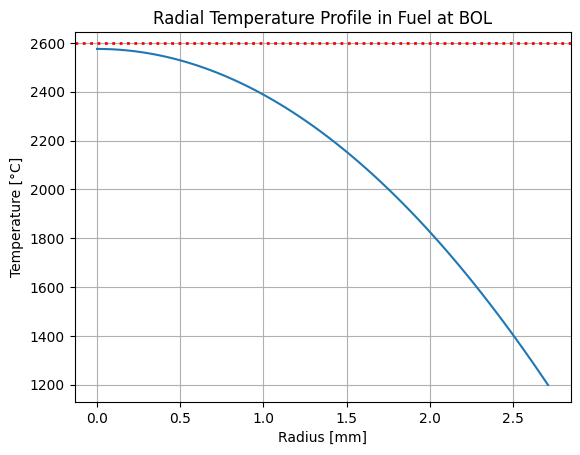

In [14]:
# RADIAL TEMPERATURE PROFILE OF FUEL AT THE HOTTEST POINT

# Design limit
T_fuel_limit = 2600 #[°C] Maximum temperature of fuel

# Inputs
T_fuel_out_K_hot = T_gap_in_hot_C + 273.15  #[K] Estimated maximum outer fuel temperature
r_fuel_out_0 = D_fuel_out/2 #[mm] Radius of fuel pellet at initial time
z_hot = T_gap_in_res.x #[m] Axial coordinate of the hottest point
x_dev_0 = 2 - OM_ratio_0 #[/] Deviation from stoichoimetry at time 0

print(f'Outer fuel temperature at the hottest axial position: {T_fuel_out_K_hot - 273.15:.2f} [°C]')

# Fuel thermal conductivity (k_0) as a function of temperature and composition
def k_fuel(T_fuel_K, x_dev, w_Pu, p, beta):
    A = 0.01926 + 1.06e-6*x_dev + 2.63e-8*w_Pu
    B = 2.39e-4 + 1.37e-13*w_Pu
    D = 5.27e9
    E = 17109.5
    k_fuel_0 = (1 / (A + B*T_fuel_K) + D / (T_fuel_K**2) * np.exp(-E / T_fuel_K)) * (1 - p)**2.5
    return 1.755 + (k_fuel_0 - 1.755) * np.exp(-beta / 128.75) #[W/m-K] Thermal conductivity of MOX fuel

# Define the temperature profile function
def T_fuel_K(r_fuel, z, k_fuel):
    C1 = (q_l(z) * 1e3 )/ (4 * np.pi * k_fuel) #[K]
    F_v = (1-(r_fuel/r_fuel_out_0)**2)
    return T_fuel_out_K_hot + C1 * F_v #[K] Radial temperature profile of fuel at hottest point at time 0

# Iterative correction for the average conductivitiy
k_fuel_out_0 = k_fuel(T_fuel_out_K_hot, x_dev_0, w_Pu_0, p_asbuilt, beta_avg) #[W/m-K]
k_fuel_asbuilt_avg = (k_fuel_out_0 + k_fuel_out_0)/2 #[W/m-K]  # Initial guess
iteration = 0
eps = 1e-4  # Convergence tolerance
max_iterations = 100  # To avoid infinite loops
print(f'Initial guess for the average thermal conductivity at the hottest axial position: {k_fuel_asbuilt_avg:.2f} [W/m-K]')

while True:
    iteration += 1
    T_fuel_K_hot = T_fuel_K(0, z_hot, k_fuel_asbuilt_avg)
    k_fuel_in_0 = k_fuel(T_fuel_K_hot, x_dev_0, w_Pu_0, p_asbuilt, beta_avg)
    k_fuel_asbuilt_avg_new = (k_fuel_in_0 + k_fuel_out_0) / 2

    if abs(k_fuel_asbuilt_avg_new - k_fuel_asbuilt_avg) < eps or iteration >= max_iterations:
        k_fuel_asbuilt_avg = k_fuel_asbuilt_avg_new
        break

    k_fuel_asbuilt_avg = k_fuel_asbuilt_avg_new

if iteration >= max_iterations:
    print("Warning: Maximum iterations reached without convergence")
print(f'Average thermal conductivity at the hottest axial position: {k_fuel_asbuilt_avg:.2f} [W/m-K]')

# Define the range of r_fuel values (from 0 to r_fuel_ext, in mm)
r_fuel_values_BOL = np.linspace(0, r_fuel_out_0, 100)  # r_fuel is in mm

# Calculate the temperature profile
T_fuel_hot_values = T_fuel_K(r_fuel_values_BOL, z_hot, k_fuel_asbuilt_avg) - 273.15 #[°C]

# Calculate the maximum temperature
print(f'Maximum temperature at fuel: {T_fuel_K(0, z_hot, k_fuel_asbuilt_avg) - 273.15:.2f} [°C]')

# Plot the results
plt.plot(r_fuel_values_BOL, T_fuel_hot_values)  # r_fuel is already in mm
plt.title('Radial Temperature Profile in Fuel at BOL')
plt.xlabel('Radius [mm]')
plt.ylabel('Temperature [°C]')
plt.axhline(T_fuel_limit, color = 'red', linestyle = ':', linewidth = 2, label ='Design limit temperature (2600°C)')
plt.grid()
plt.show()

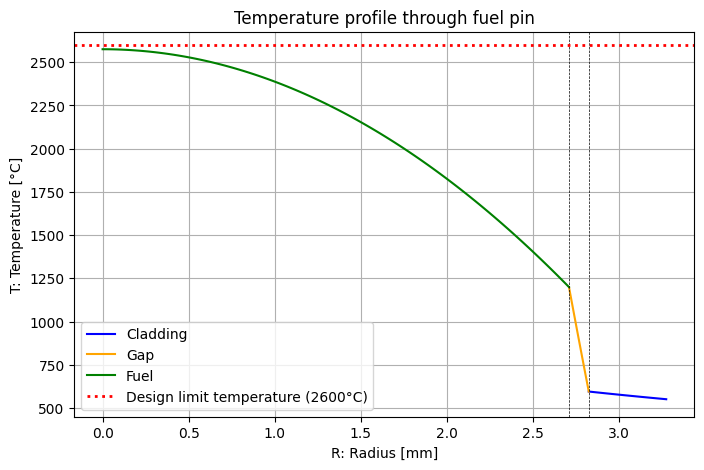

In [15]:
# RADIAL TEMPERATURE PROFILE AT THE ESTIMATED HOTTEST POINT at BOL

# Plotting multiple graphs
plt.figure(figsize=(8, 5))   # Set the figure size
plt.plot(r_clad_values, T_clad_hot_values, label = 'Cladding', color = 'blue')
plt.plot(r_gap_values, T_gap_hot_values, label = 'Gap', color = 'orange')
plt.plot(r_fuel_values_BOL, T_fuel_hot_values, label = 'Fuel', color = 'green')
plt.title('Temperature profile through fuel pin')
plt.xlabel('R: Radius [mm]')
plt.ylabel('T: Temperature [°C]')
plt.axvline(r_clad_in, color='black',linewidth=0.5, ls='--')
plt.axvline(r_fuel_out_0, color='black',linewidth=0.5, ls='--')
plt.axhline(T_fuel_limit, color = 'red', linestyle = ':', linewidth = 2, label ='Design limit temperature (2600°C)')
plt.grid()
plt.legend()
plt.show()

## Neutron flux (Beginning of Life Analysis)


6100000000000000.0
Neutron flux in extrapolated radius -1336028024618146.5


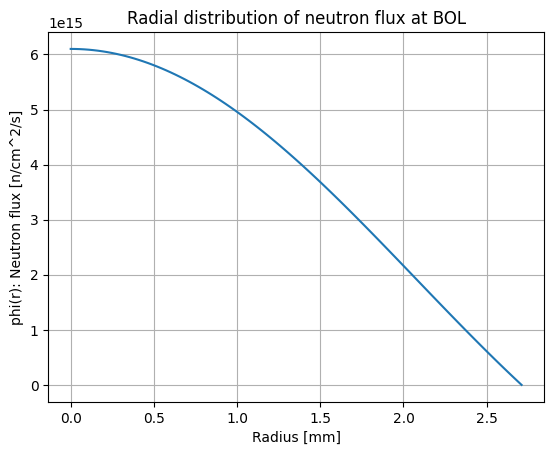

In [16]:
# Neutron Flux as a function of the radius at BOL

def phi_BOL(r_fuel):
  R_ext = 1 * r_fuel_out_0
  nu_0 = 2.405
  return phi_0 * j0(nu_0 * r_fuel / R_ext) #[n/cm^2-s] Neutron flux at peak power. Where j0 is the zeroth-order Bessel function

phi_BOL_values = phi_BOL(r_fuel_values_BOL)
J_nu = j0(2.405)
phi_R_ext = phi_BOL(1.2 * r_fuel_out_0)
print(phi_BOL(0))
print(f'Neutron flux in extrapolated radius {phi_R_ext}')

plt.plot(r_fuel_values_BOL, phi_BOL_values)
plt.title('Radial distribution of neutron flux at BOL')
plt.xlabel('Radius [mm]')
plt.ylabel('phi(r): Neutron flux [n/cm^2/s]')
plt.grid()
plt.show()

## Radial compositions (BOL Analysis)

In [17]:
# Radial composition of constituents in Fuel at BOL

# Input molar mass of different isotopes
M_O = 16 #[g/mol]
M_U235 = 235 #[g/mol]
M_U238 = 238 #[g/mol]
M_Pu239 = 239 #[g/mol]
M_Pu240 = 240 #[g/mol]
M_Pu241 = 241 #[g/mol]

# Calculation of initial molar composition of the MOX fuel
V_fuel_0 = np.pi* r_fuel_out_0 **2 *H_fuel_0 * 1e-9 #[m^3] Reference volume of fuel
m_fuel_0 = rho_fuel_0 * V_fuel_0/1000 #[ton-MOx] Weight of fuel material per fuel rod
x_U235_0 = (w_U235_0/M_U235) / ((w_U235_0/M_U235) + (w_U238_0/M_U238)) #[/] Molar fraction of U-235 in natural Uranium
x_U238_0 = 1 - x_U235_0  #[/] Molar fraction of U-238 in natural Uranium
x_Pu239_0 = (w_Pu239_0/M_Pu239) / ((w_Pu239_0/M_Pu239) + (w_Pu240_0/M_Pu240) + (w_Pu241_0/M_Pu241)) #[/] Molar fraction of Pu-239 in fresh MOX
x_Pu240_0 = (w_Pu240_0/M_Pu240) / ((w_Pu239_0/M_Pu239) + (w_Pu240_0/M_Pu240) + (w_Pu241_0/M_Pu241)) #[/] Molar fraction of Pu-240 in fresh MOX
x_Pu241_0 = 1 - x_Pu239_0 - x_Pu240_0  #[/] Molar fraction of Pu-241 in fresh MOX
M_U_0 = x_U235_0*M_U235 + x_U238_0*M_U238 #[g/gmol] Molar mass of Uranium
M_Pu_0 = x_Pu239_0*M_Pu239 + x_Pu240_0*M_Pu240 + x_Pu241_0*M_Pu241 #[g/gmol] Molar mass of Plutonium
w_U_0 = 1 - w_Pu_0 #[/] Initial mass fraction of Uranium in MOX
x_Pu_0 = (w_Pu_0/M_Pu_0) / ((w_Pu_0/M_Pu_0) + (w_U_0/M_U_0)) #[/] Molar fraction of Pu in MOX
x_U_0 = 1 - x_Pu_0 #[/] Molar fraction of U in MOX
M_HM_0 = x_Pu_0*M_Pu_0 + x_U_0*M_U_0  #[g/gmol] Molar mass of Heavy Metal
n_HM_0 = m_fuel_0 / (M_HM_0 + OM_ratio_0 * M_O)  #[ton-mol] Moles of Heavy Metal in MOX
n_O_0 = OM_ratio_0 * n_HM_0 #[ton-mol] Numero de moles de Oxygen
m_HM_0 = n_HM_0 * M_HM_0 #[ton_HM] Toneladas de Heavy Metal

# Calculation of initial atomic concentrations
N_U235_0 = x_U235_0 * (n_HM_0 * x_U_0) * 6.022e23 / V_fuel_0  #[atoms/cm^3]
N_U238_0 = x_U238_0 * (n_HM_0 * x_U_0) * 6.022e23 / V_fuel_0 #[atoms/cm^3]
N_Pu239_0 = x_Pu239_0 * (n_HM_0 * x_Pu_0) * 6.022e23 / V_fuel_0 #[atoms/cm^3]
N_Pu240_0 = x_Pu240_0 * (n_HM_0 * x_Pu_0) * 6.022e23 / V_fuel_0 #[atoms/cm^3]
N_Pu241_0 = x_Pu241_0 * (n_HM_0 * x_Pu_0) * 6.022e23 / V_fuel_0 #[atoms/cm^3]
N_U_0 = n_HM_0 * x_U_0 * 6.022e23 / V_fuel_0 #[atoms/cm^3]
N_Pu_0 = n_HM_0 * x_Pu_0 * 6.022e23 / V_fuel_0 #[atoms/cm^3]

n_total_0 = (N_U_0 + N_Pu_0) * V_fuel_0 / 6.022e23

print(f'Initial atomic concentration of U-235: {N_U235_0:.4e} [atoms/cm^3]')
print(f'Initial atomic concentration of U-238: {N_U238_0:.4e} [atoms/cm^3]')
print(f'Initial atomic concentration of Pu-239: {N_Pu239_0:.4e} [atoms/cm^3]')
print(f'Initial atomic concentration of Pu-240: {N_Pu240_0:.4e} [atoms/cm^3]')
print(f'Initial atomic concentration of Pu-241: {N_Pu241_0:.4e} [atoms/cm^3]')

Initial atomic concentration of U-235: 1.2221e+20 [atoms/cm^3]
Initial atomic concentration of U-238: 1.6851e+22 [atoms/cm^3]
Initial atomic concentration of Pu-239: 4.8321e+21 [atoms/cm^3]
Initial atomic concentration of Pu-240: 1.3749e+21 [atoms/cm^3]
Initial atomic concentration of Pu-241: 6.8457e+20 [atoms/cm^3]


## Average isotopic concentrations (BOL Analysis)

Atomic concentration of U-235: 9.5471e+19 atoms/cm^3 at radius 0.0 mm
Atomic concentration of U-235: 1.0783e+20 atoms/cm^3 at radius 1.7 mm
Atomic concentration of U-235: 1.2221e+20 atoms/cm^3 at radius 2.7 mm
Atomic concentration of U-238: 1.6503e+22 atoms/cm^3 at radius 0.0 mm
Atomic concentration of U-238: 1.6674e+22 atoms/cm^3 at radius 1.7 mm
Atomic concentration of U-238: 1.6851e+22 atoms/cm^3 at radius 2.7 mm
Atomic concentration of U-238: 3.8165e+21 atoms/cm^3 at radius 0.0 mm
Atomic concentration of U-238: 4.2780e+21 atoms/cm^3 at radius 1.7 mm
Atomic concentration of U-238: 4.8322e+21 atoms/cm^3 at radius 2.7 mm
Atomic concentration of U-238: 1.0406e+21 atoms/cm^3 at radius 0.0 mm
Atomic concentration of U-238: 1.1928e+21 atoms/cm^3 at radius 1.7 mm
Atomic concentration of U-238: 1.3749e+21 atoms/cm^3 at radius 2.7 mm
Atomic concentration of U-238: 5.1960e+20 atoms/cm^3 at radius 0.0 mm
Atomic concentration of U-238: 5.9477e+20 atoms/cm^3 at radius 1.7 mm
Atomic concentration

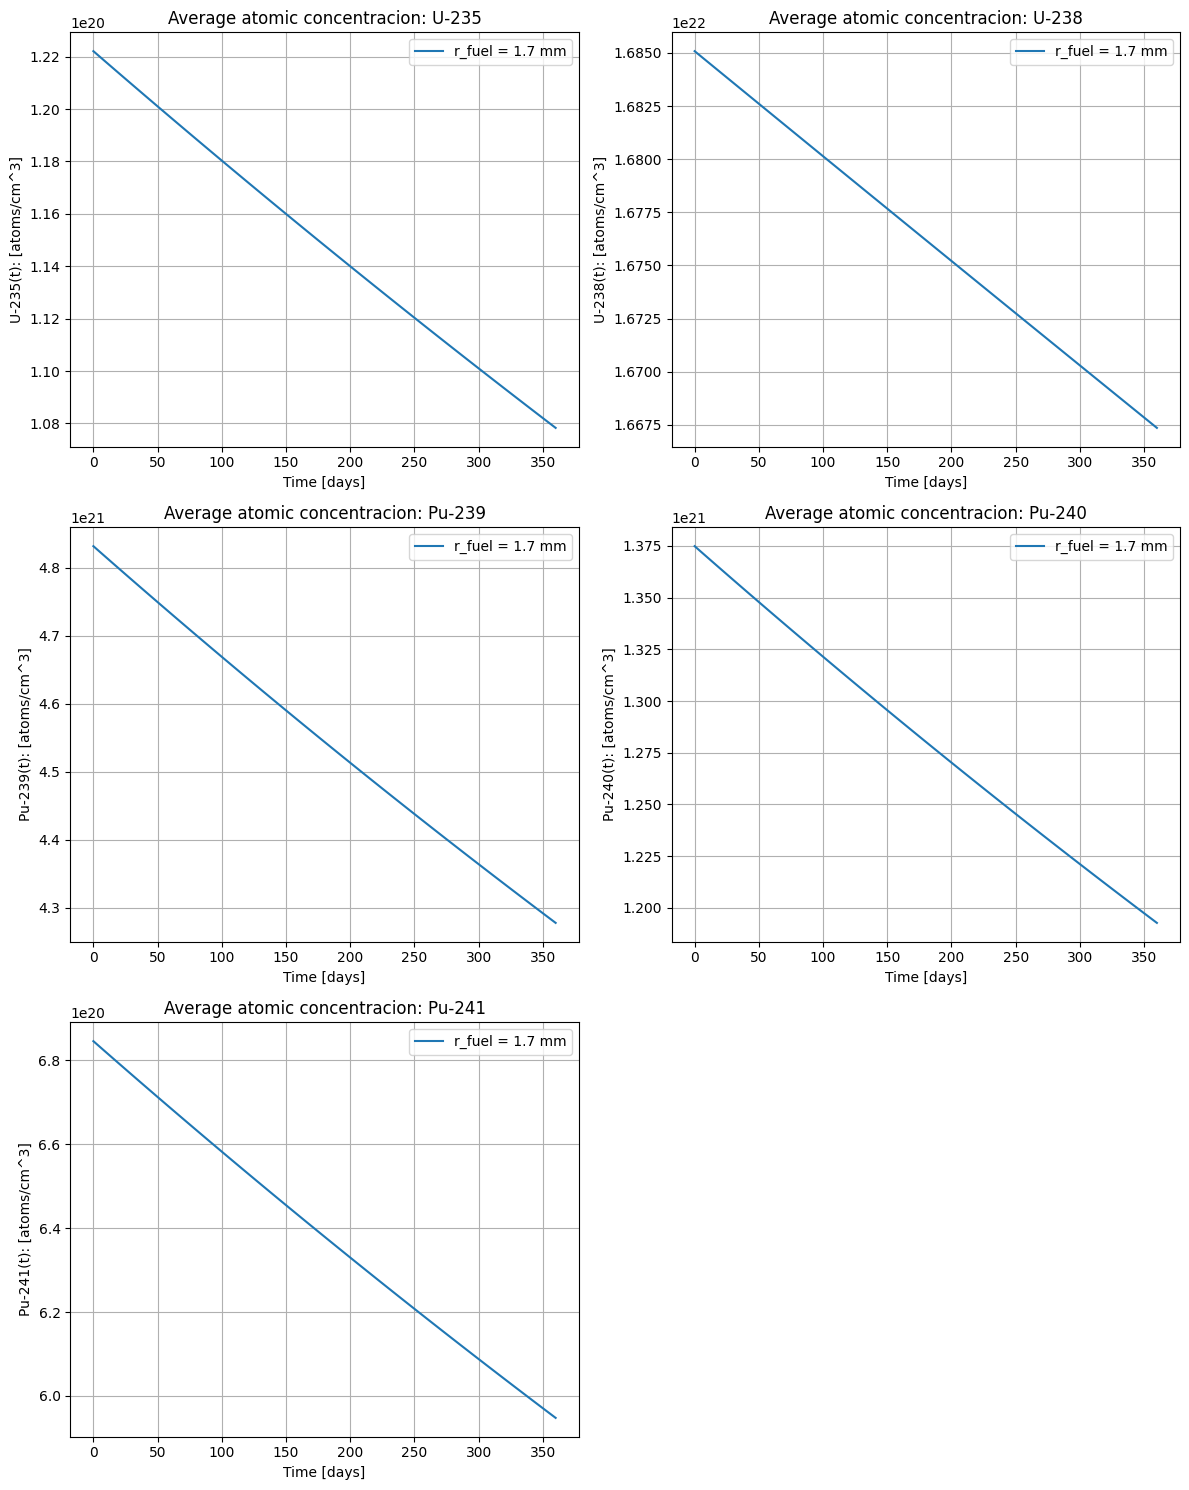

In [18]:
# Average concentrations in the fuel

# Input data cross sections
sigma_U235_nf = 1.138118 #[b] Fission cross section @0.5 MeV
sigma_U238_nf = 3.7642e-4 #[b] Fission cross section @0.5 MeV
sigma_Pu239_nf = 1.565655 #[b] Fission cross section @0.5 MeV
sigma_Pu240_nf = 0.4178659 #[b] Fission cross section @0.5 MeV
sigma_Pu241_nf = 1.5212 #[b] Fission cross section @0.5 MeV

sigma_U235_ng = 0.16316 #[b] Radiative capture cross section @0.5 MeV
sigma_U238_ng = 0.10959 #[b] Radiative capture cross section @0.5 MeV
sigma_Pu239_ng = 	0.104844 #[b] Radiative capture cross section @0.5 MeV
sigma_Pu240_ng = 0.1280016 #[b] Radiative capture cross section @0.5 MeV
sigma_Pu241_ng = 0.13602 #[b] Radiative capture cross section @0.5 MeV

sigma_U235_na = sigma_U235_nf + sigma_U235_ng #[b] Absorption cross section @0.5 MeV
sigma_U238_na = sigma_U238_nf + sigma_U238_ng #[b] Absorption cross section @0.5 MeV
sigma_Pu239_na = sigma_Pu239_nf + sigma_Pu239_ng #[b] Absorption cross section @0.5 MeV
sigma_Pu240_na = sigma_Pu240_nf + sigma_Pu240_ng #[b] Absorption cross section @0.5 MeV
sigma_Pu241_na = sigma_Pu241_nf + sigma_Pu241_ng #[b] Absorption cross section @0.5 MeV

def N_U235_avg(r_fuel_avg, t):
    return N_U235_0 * np.exp(-sigma_U235_na * 1e-24 * phi_BOL(r_fuel_avg) * t) #[atoms/cm^3] Average concentration of U235 at time t

def N_U238_avg(r_fuel_avg, t):
    return N_U238_0 * np.exp(-sigma_U238_na * 1e-24 * phi_BOL(r_fuel_avg) * t) #[atoms/cm^3] Average concentration of U238 at time t

def N_Pu239_avg(r_fuel_avg, t):
    C = N_U238_0 * sigma_U238_ng / (sigma_Pu239_na - sigma_U238_ng) #[atoms/cm^3]
    return (N_Pu239_0 - C) * np.exp(-sigma_Pu239_na * 1e-24 * phi_BOL(r_fuel_avg) * t) + C * np.exp(-sigma_U238_na * 1e-24 * phi_BOL(r_fuel_avg) * t) #[atoms/cm^3] Average concentration of U235 at time t

def N_Pu240_avg(r_fuel_avg, t):
    C = N_Pu239_0 * sigma_Pu239_ng / (sigma_Pu240_na - sigma_Pu239_ng) #[atoms/cm^3]
    return (N_Pu240_0 - C) * np.exp(-sigma_Pu240_na * 1e-24 * phi_BOL(r_fuel_avg) * t) + C * np.exp(-sigma_Pu239_na * 1e-24 * phi_BOL(r_fuel_avg) * t) #[atoms/cm^3] Average concentration of U235 at time t

def N_Pu241_avg(r_fuel_avg, t):
    C = N_Pu240_0 * sigma_Pu240_ng / (sigma_Pu241_na - sigma_Pu240_ng) #[atoms/cm^3]
    return (N_Pu241_0 - C) * np.exp(-sigma_Pu241_na * 1e-24 * phi_BOL(r_fuel_avg) * t) + C * np.exp(-sigma_Pu240_na * 1e-24 * phi_BOL(r_fuel_avg) * t) #[atoms/cm^3] Average concentration of U235 at time t

r_fuel_avg = 1.7 #[mm]
t_EOL = t_cycle * 24 * 3600 #[s]
r_fuel_eval = [0.0, r_fuel_avg, r_fuel_out_0] #[mm]


for r_fuel in r_fuel_eval:
    N_U235_avg_eval = N_U235_avg(r_fuel, t_EOL)
    print(f"Atomic concentration of U-235: {N_U235_avg_eval:.4e} atoms/cm^3 at radius {r_fuel:.1f} mm")

for r_fuel in r_fuel_eval:
    N_U238_avg_eval = N_U238_avg(r_fuel, t_EOL)
    print(f'Atomic concentration of U-238: {N_U238_avg_eval:.4e} atoms/cm^3 at radius {r_fuel:.1f} mm')

for r_fuel in r_fuel_eval:
    N_Pu239_avg_eval = N_Pu239_avg(r_fuel, t_EOL)
    print(f'Atomic concentration of U-238: {N_Pu239_avg_eval:.4e} atoms/cm^3 at radius {r_fuel:.1f} mm')

for r_fuel in r_fuel_eval:
    N_Pu240_avg_eval = N_Pu240_avg(r_fuel, t_EOL)
    print(f'Atomic concentration of U-238: {N_Pu240_avg_eval:.4e} atoms/cm^3 at radius {r_fuel:.1f} mm')

for r_fuel in r_fuel_eval:
    N_Pu241_avg_eval = N_Pu241_avg(r_fuel, t_EOL)
    print(f'Atomic concentration of U-238: {N_Pu241_avg_eval:.4e} atoms/cm^3 at radius {r_fuel:.1f} mm')

t_values = np.linspace(0,t_cycle*24*3600,100)

N_U235_avg_values = N_U235_avg(r_fuel_avg, t_values)
N_U238_avg_values = N_U238_avg(r_fuel_avg, t_values)
N_Pu239_avg_values = N_Pu239_avg(r_fuel_avg, t_values)
N_Pu240_avg_values = N_Pu240_avg(r_fuel_avg, t_values)
N_Pu241_avg_values = N_Pu241_avg(r_fuel_avg, t_values)

# Variation of average isotopic concentration with time
fig, axs = plt.subplots(3, 2, figsize=(12, 15))
(ax1, ax2), (ax3, ax4), (ax5, ax6)= axs

ax1.plot(t_values/(24*3600), N_U235_avg_values, label=f"r_fuel = {r_fuel_avg:.1f} mm")
ax1.set_title(f'Average atomic concentracion: U-235')
ax1.set_xlabel('Time [days]')
ax1.set_ylabel('U-235(t): [atoms/cm^3]')
ax1.legend()
ax1.grid()

ax2.plot(t_values/(24*3600), N_U238_avg_values, label=f"r_fuel = {r_fuel_avg:.1f} mm")
ax2.set_title(f'Average atomic concentracion: U-238')
ax2.set_xlabel('Time [days]')
ax2.set_ylabel('U-238(t): [atoms/cm^3]')
ax2.legend()
ax2.grid()

ax3.plot(t_values/(24*3600), N_Pu239_avg_values, label=f"r_fuel = {r_fuel_avg:.1f} mm")
ax3.set_title(f'Average atomic concentracion: Pu-239')
ax3.set_xlabel('Time [days]')
ax3.set_ylabel('Pu-239(t): [atoms/cm^3]')
ax3.legend()
ax3.grid()

ax4.plot(t_values/(24*3600), N_Pu240_avg_values, label=f"r_fuel = {r_fuel_avg:.1f} mm")
ax4.set_title(f'Average atomic concentracion: Pu-240')
ax4.set_xlabel('Time [days]')
ax4.set_ylabel('Pu-240(t): [atoms/cm^3]')
ax4.legend()
ax4.grid()

ax5.plot(t_values/(24*3600), N_Pu241_avg_values, label=f"r_fuel = {r_fuel_avg:.1f} mm")
ax5.set_title(f'Average atomic concentracion: Pu-241')
ax5.set_xlabel('Time [days]')
ax5.set_ylabel('Pu-241(t): [atoms/cm^3]')
ax5.legend()
ax5.grid()

ax6.axis('off')

plt.tight_layout()
plt.show()

## Evolution of Burnup with time (BOL Analysis)

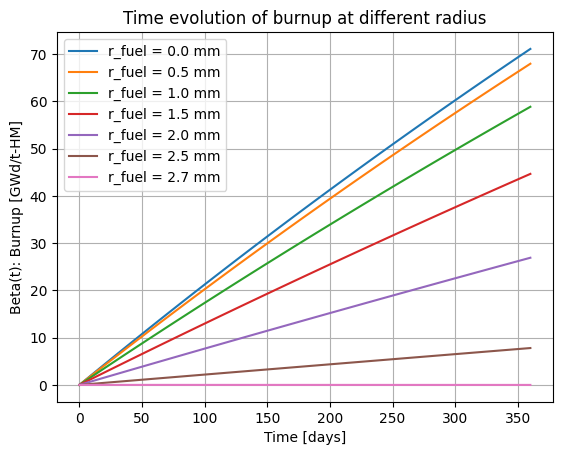

In [19]:
# Updated Burnup with last composition

def beta5(r_fuel, t):
    N_U235_avg_int = N_U235_0 * (1 - np.exp(-sigma_U235_na * 1e-24 * phi_BOL(r_fuel) * t)) #[atoms/cm^3]
    N_U238_avg_int = N_U238_0 * (1 - np.exp(-sigma_U238_na * 1e-24 * phi_BOL(r_fuel) * t)) #[atoms/cm^3]
    C_Pu_239 = N_U238_0 * sigma_U238_ng / (sigma_Pu239_na - sigma_U238_ng) #[atoms/cm^3]
    N_Pu239_avg_int = (N_Pu239_0 - C_Pu_239) * (1 - np.exp(-sigma_Pu239_na * 1e-24 * phi_BOL(r_fuel) * t)) + C_Pu_239 * sigma_Pu239_na / sigma_U238_na * (1 - np.exp(-sigma_U238_na * 1e-24 * phi_BOL(r_fuel) * t))
    C_Pu_240 = N_Pu239_0 * sigma_Pu239_ng / (sigma_Pu240_na - sigma_Pu239_ng) #[atoms/cm^3]
    N_Pu240_avg_int = (N_Pu240_0 - C_Pu_240) * (1 - np.exp(-sigma_Pu240_na * 1e-24 * phi_BOL(r_fuel) * t)) + C_Pu_240 * sigma_Pu240_na / sigma_Pu239_na * (1 - np.exp(-sigma_Pu239_na * 1e-24 * phi_BOL(r_fuel) * t))
    C_Pu_241 = N_Pu240_0 * sigma_Pu240_ng / (sigma_Pu241_na - sigma_Pu240_ng) #[atoms/cm^3]
    N_Pu241_avg_int = (N_Pu241_0 - C_Pu_241) * (1 - np.exp(-sigma_Pu241_na * 1e-24 * phi_BOL(r_fuel) * t)) + C_Pu_241 * sigma_Pu241_na / sigma_Pu240_na * (1 - np.exp(-sigma_Pu240_na * 1e-24 * phi_BOL(r_fuel) * t))
    Fission_rate = N_U235_avg_int + N_U238_avg_int + N_Pu239_avg_int + N_Pu240_avg_int + N_Pu241_avg_int #[fissions/cm^3-s] Total number of fission events
    return  Fission_rate * 3.708E-25 / (rho_fuel_0 / 1e9) #[GWd/t_HM]

r_fuel_eval = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, r_fuel_out_0] #[mm]

for r_fuel in r_fuel_eval:
    beta_values = [beta5(r_fuel, t) for t in t_values]
    plt.plot(t_values/(24*3600), beta_values, label=f"r_fuel = {r_fuel:.1f} mm")
plt.title(f'Time evolution of burnup at different radius')
plt.xlabel('Time [days]')
plt.ylabel('Beta(t): Burnup [GWd/t-HM]')
plt.legend()
plt.grid()
plt.show()

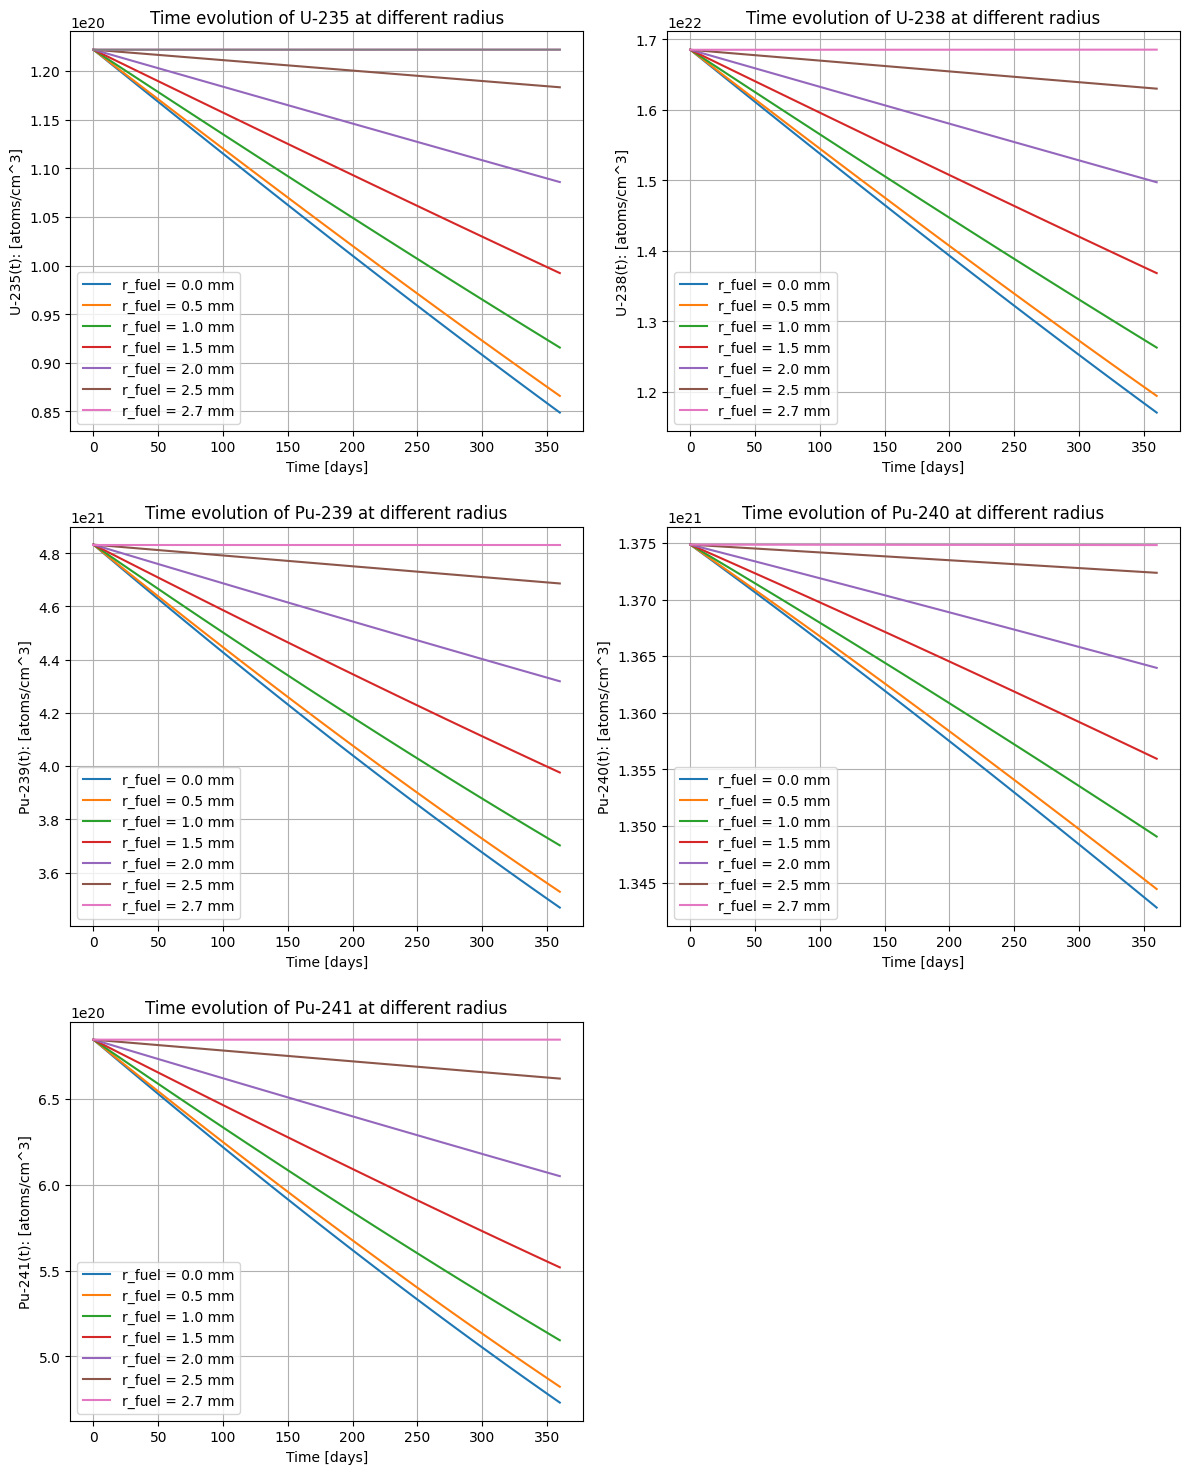

In [20]:
# Local Concentrations and Radial Profiles

def A(r_fuel, t):
  Sigma_tot_f = (N_U235_avg(r_fuel, t) * sigma_U235_nf + N_U238_avg(r_fuel, t) * sigma_U238_nf + N_Pu239_avg(r_fuel, t) * sigma_Pu239_nf
                 + N_Pu240_avg(r_fuel, t) * sigma_Pu240_nf + N_Pu241_avg(r_fuel, t) * sigma_Pu241_nf)* 1e-24
  return (rho_fuel_0 / 1e9) / (3.708E-25 * Sigma_tot_f)   #[t_HM/GWd-cm^2]

def N_U235(r_fuel,t):
    beta = beta5(r_fuel, t) #[GWd/t_HM]
    return N_U235_0 * np.exp(-sigma_U235_na * 1e-24 * A(r_fuel, t) * beta) #[atoms/cm^3]

def N_U238(r_fuel,t):
    beta = beta5(r_fuel, t) #[GWd/t_HM]
    f_r = 1 + 3 * np.exp(-9.7 * (r_fuel_out_0 - r_fuel)**0.5)
    return N_U238_0 * np.exp(-sigma_U235_na * 1e-24 * A(r_fuel, t) * f_r * beta) #[atoms/cm^3]

def N_Pu239(r_fuel,t):
    beta = beta5(r_fuel, t) #[GWd/t_HM]
    f_r = 1 + 3 * np.exp(-9.7 * (r_fuel_out_0 - r_fuel)**0.5 )
    term1 = (sigma_U238_ng * N_U238_0 * f_r) / (sigma_Pu239_na - sigma_U238_ng)
    term2 = (1 - np.exp(-sigma_Pu239_na * 1e-24 * A(r_fuel, t) * beta))
    term3 = N_Pu239_0 * np.exp(-sigma_Pu239_na * 1e-24 * A(r_fuel, t) * beta)
    return term1 * term2 + term3 #[atoms/cm^3]

def N_Pu240(r_fuel,t):
    beta = beta5(r_fuel, t) #[GWd/t_HM]
    f_r = 1 + 3 * np.exp(-9.7 * (r_fuel_out_0 - r_fuel)**0.5 )
    term1 = (sigma_Pu239_ng * N_Pu239_0 * f_r) / (sigma_Pu240_na - sigma_Pu239_ng)
    term2 = (1 - np.exp(-sigma_Pu240_na * 1e-24 * A(r_fuel, t) * beta))
    term3 = N_Pu240_0 * np.exp(-sigma_Pu240_na * 1e-24 * A(r_fuel, t) * beta)
    return term1 * term2 + term3 #[atoms/cm^3]

def N_Pu241(r_fuel,t):
    beta = beta5(r_fuel, t) #[GWd/t_HM]
    f_r = 1 + 3 * np.exp(-9.7 * (r_fuel_out_0 - r_fuel)**0.5 )
    term1 = (sigma_Pu240_ng * N_Pu240_0 * f_r) / (sigma_Pu241_na - sigma_Pu240_ng)
    term2 = (1 - np.exp(-sigma_Pu241_na * 1e-24 * A(r_fuel, t) * beta))
    term3 = N_Pu241_0 * np.exp(-sigma_Pu241_na * 1e-24 * A(r_fuel, t) * beta)
    return term1 * term2 + term3 #[atoms/cm^3]

# Isotopic concentration at different radius of the fuel
fig, axs = plt.subplots(3, 2, figsize=(12, 15))
(ax1, ax2), (ax3, ax4), (ax5, ax6)= axs

for r_fuel in r_fuel_eval:
    N_U235_values = [N_U235(r_fuel, t) for t in t_values]
    ax1.plot(t_values/(24*3600), N_U235_values, label=f"r_fuel = {r_fuel:.1f} mm")
ax1.plot(t_values/(24*3600), N_U235_values)
ax1.set_title(f'Time evolution of U-235 at different radius')
ax1.set_xlabel('Time [days]')
ax1.set_ylabel('U-235(t): [atoms/cm^3]')
ax1.legend()
ax1.grid()

for r_fuel in r_fuel_eval:
    N_U238_values = [N_U238(r_fuel, t) for t in t_values]
    ax2.plot(t_values/(24*3600), N_U238_values, label=f"r_fuel = {r_fuel:.1f} mm")
ax2.set_title(f'Time evolution of U-238 at different radius')
ax2.set_xlabel('Time [days]')
ax2.set_ylabel('U-238(t): [atoms/cm^3]')
ax2.legend()
ax2.grid()

for r_fuel in r_fuel_eval:
    N_Pu239_values = [N_Pu239(r_fuel, t) for t in t_values]
    ax3.plot(t_values/(24*3600), N_Pu239_values, label=f"r_fuel = {r_fuel:.1f} mm")
ax3.set_title(f'Time evolution of Pu-239 at different radius')
ax3.set_xlabel('Time [days]')
ax3.set_ylabel('Pu-239(t): [atoms/cm^3]')
ax3.legend()
ax3.grid()

for r_fuel in r_fuel_eval:
    N_Pu240_values = [N_Pu240(r_fuel, t) for t in t_values]
    ax4.plot(t_values/(24*3600), N_Pu240_values, label=f"r_fuel = {r_fuel:.1f} mm")
ax4.set_title(f'Time evolution of Pu-240 at different radius')
ax4.set_xlabel('Time [days]')
ax4.set_ylabel('Pu-240(t): [atoms/cm^3]')
ax4.legend()
ax4.grid()

for r_fuel in r_fuel_eval:
    N_Pu241_values = [N_Pu241(r_fuel, t) for t in t_values]
    ax5.plot(t_values/(24*3600), N_Pu241_values, label=f"r_fuel = {r_fuel:.1f} mm")
ax5.set_title(f'Time evolution of Pu-241 at different radius')
ax5.set_xlabel('Time [days]')
ax5.set_ylabel('Pu-241(t): [atoms/cm^3]')
ax5.legend()
ax5.grid()

ax6.axis('off')

plt.tight_layout()
plt.show()

## Normalized concentrations at the EOL (BOL Analysis)



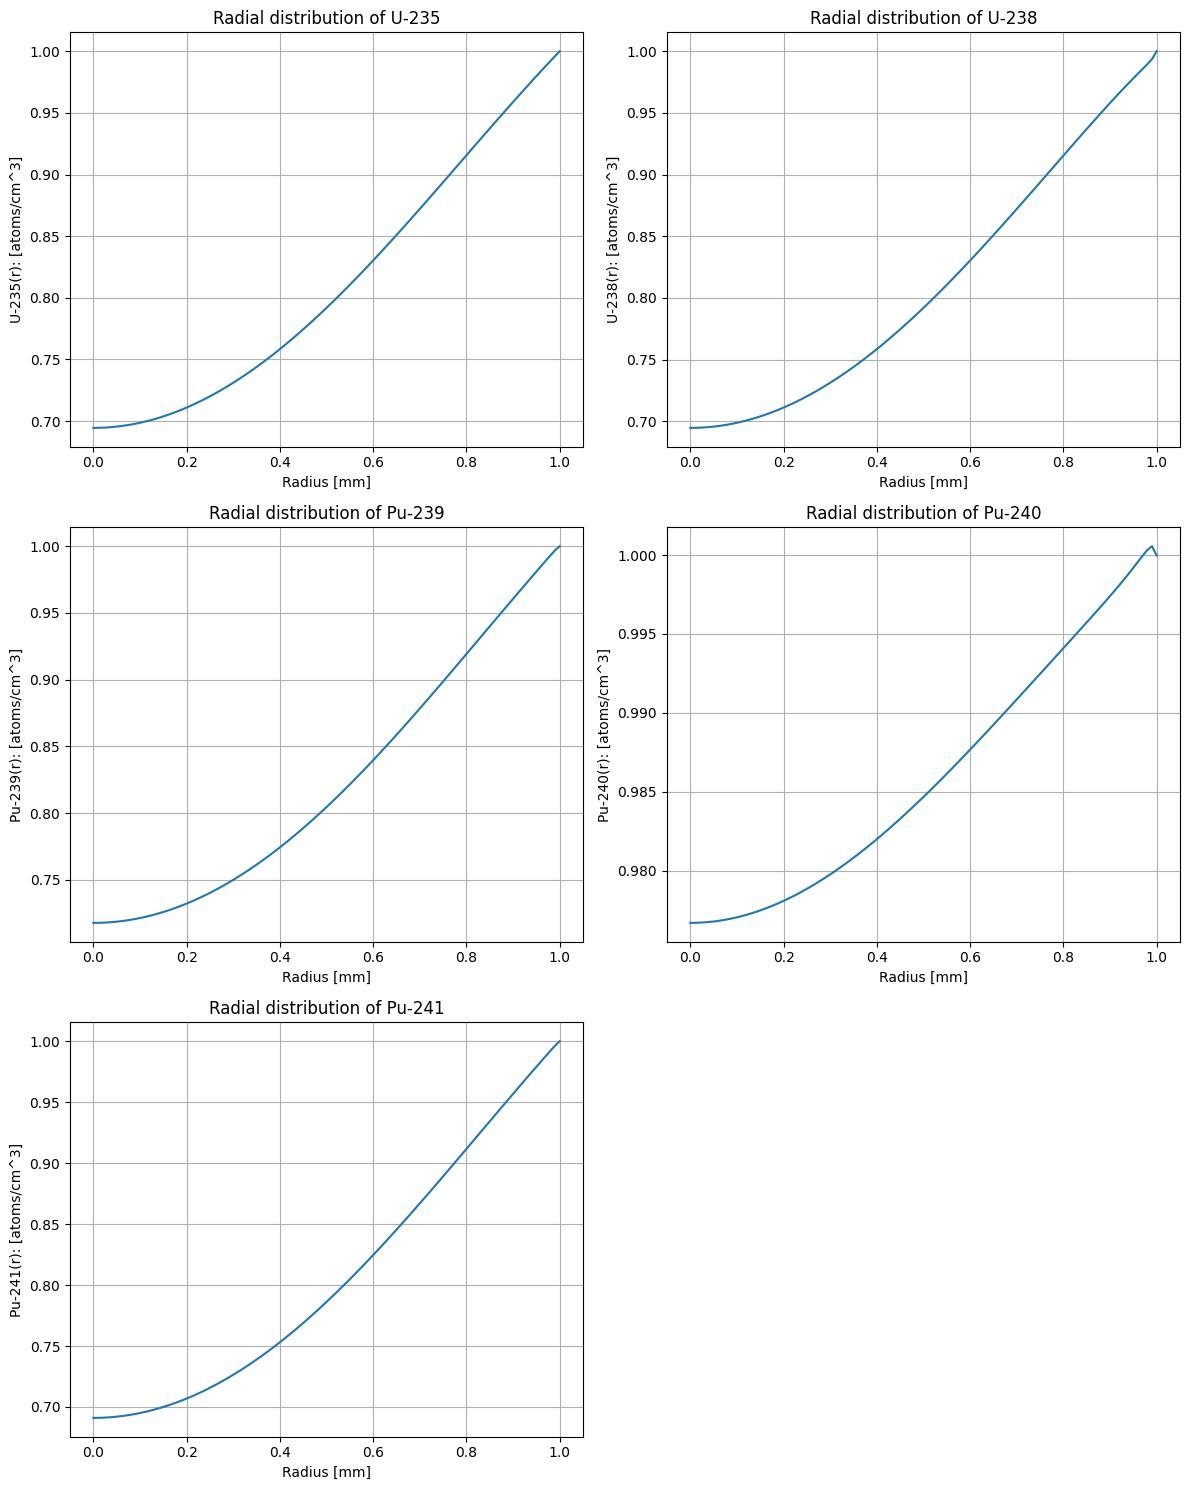

In [21]:
N_U235_values = N_U235(r_fuel_values_BOL, t_EOL)  #[atoms/cm^3]
N_U238_values = N_U238(r_fuel_values_BOL, t_EOL)  #[atoms/cm^3]
N_Pu239_values = N_Pu239(r_fuel_values_BOL, t_EOL)  #[atoms/cm^3]
N_Pu240_values = N_Pu240(r_fuel_values_BOL, t_EOL)  #[atoms/cm^3]
N_Pu241_values = N_Pu241(r_fuel_values_BOL, t_EOL)  #[atoms/cm^3]

# Normalization
r_fuel_values_n = r_fuel_values_BOL / r_fuel_out_0
N_U235_values_n = N_U235_values / N_U235_0
N_U238_values_n = N_U238_values / N_U238_0
N_Pu239_values_n = N_Pu239_values / N_Pu239_0
N_Pu240_values_n = N_Pu240_values / N_Pu240_0
N_Pu241_values_n = N_Pu241_values / N_Pu241_0

# Create a figure with two subplots arranged in 1 row and 2 columns
fig, axs = plt.subplots(3, 2, figsize=(12, 15))
(ax1, ax2), (ax3, ax4), (ax5, ax6)= axs

ax1.plot(r_fuel_values_n, N_U235_values_n)
ax1.set_title('Radial distribution of U-235')
ax1.set_xlabel('Radius [mm]')
ax1.set_ylabel('U-235(r): [atoms/cm^3]')
ax1.grid()

ax2.plot(r_fuel_values_n, N_U238_values_n)
ax2.set_title('Radial distribution of U-238')
ax2.set_xlabel('Radius [mm]')
ax2.set_ylabel('U-238(r): [atoms/cm^3]')
ax2.grid()

ax3.plot(r_fuel_values_n, N_Pu239_values_n)  # Assuming you want to plot Pu-239 here
ax3.set_title('Radial distribution of Pu-239')
ax3.set_xlabel('Radius [mm]')
ax3.set_ylabel('Pu-239(r): [atoms/cm^3]')
ax3.grid()

ax4.plot(r_fuel_values_n, N_Pu240_values_n)  # Assuming you want to plot Pu-239 here
ax4.set_title('Radial distribution of Pu-240')
ax4.set_xlabel('Radius [mm]')
ax4.set_ylabel('Pu-240(r): [atoms/cm^3]')
ax4.grid()

ax5.plot(r_fuel_values_n, N_Pu241_values_n)  # Assuming you want to plot Pu-239 here
ax5.set_title('Radial distribution of Pu-241')
ax5.set_xlabel('Radius [mm]')
ax5.set_ylabel('Pu-241(r): [atoms/cm^3]')
ax5.grid()

ax6.axis('off')  # Remove the fourth subplot (if unnecessary)

plt.tight_layout()
plt.show()

In [22]:
# Calculation of average atomic concentrations at the EOL

N_U235_EOL = N_U235_avg(r_fuel_avg, t_EOL) #[atoms/cm^3]
N_U238_EOL = N_U238_avg(r_fuel_avg, t_EOL) #[atoms/cm^3]
N_Pu239_EOL = N_Pu239_avg(r_fuel_avg, t_EOL) #[atoms/cm^3]
N_Pu240_EOL = N_Pu240_avg(r_fuel_avg, t_EOL) #[atoms/cm^3]
N_Pu241_EOL = N_Pu241_avg(r_fuel_avg, t_EOL) #[atoms/cm^3]

print(f'Average atomic concentration of U-235 at EOL: {N_U235_EOL:.4e} [atoms/cm^3]')
print(f'Average atomic concentration of U-238 at EOL: {N_U238_EOL:.4e} [atoms/cm^3]')
print(f'Average atomic concentration of Pu-239 at EOL: {N_Pu239_EOL:.4e} [atoms/cm^3]')
print(f'Average atomic concentration of Pu-240 at EOL: {N_Pu240_EOL:.4e} [atoms/cm^3]')
print(f'Average atomic concentration of Pu-241 at EOL: {N_Pu241_EOL:.4e} [atoms/cm^3]')

Average atomic concentration of U-235 at EOL: 1.0783e+20 [atoms/cm^3]
Average atomic concentration of U-238 at EOL: 1.6674e+22 [atoms/cm^3]
Average atomic concentration of Pu-239 at EOL: 4.2780e+21 [atoms/cm^3]
Average atomic concentration of Pu-240 at EOL: 1.1928e+21 [atoms/cm^3]
Average atomic concentration of Pu-241 at EOL: 5.9477e+20 [atoms/cm^3]


In [23]:
x_U235_EOL = N_U235_EOL / (N_U235_EOL + N_U238_EOL) #[/] Molar fraction of U-235 in spent Uranium fraction
x_U238_EOL = 1 - x_U235_EOL #[/] Molar fraction of U-238 in spent Uranium fraction
x_Pu239_EOL = N_Pu239_EOL / (N_Pu239_EOL + N_Pu239_EOL + N_Pu239_EOL) #[/] Molar fraction of U-239 in spent Plutonium fraction
x_Pu240_EOL = N_Pu240_EOL / (N_Pu239_EOL + N_Pu239_EOL + N_Pu239_EOL)
x_Pu241_EOL = 1 - x_Pu239_EOL - x_Pu240_EOL

x_U_0 = x_U235_0 + x_U238_0
x_Pu_0 = x_Pu239_0 + x_Pu240_0 + x_Pu241_0
x_U_EOL = x_U235_EOL + x_U238_EOL
x_Pu_EOL = x_Pu239_EOL + x_Pu240_EOL + x_Pu241_EOL

print(f'Initial and final molar fraction of U-235: {x_U235_0:.4e} {x_U235_EOL:.4e}')
print(f'Initial and final molar fraction of U-238: {x_U238_0:.4e} {x_U238_EOL:.4e}')
print(f'Initial and final molar fraction of U: {x_U_0:.4e} {x_U_EOL:.4e}')
print(f'Initial and final molar fraction of Pu-239: {x_Pu239_0:.4e} {x_Pu239_EOL:.4e}')
print(f'Initial and final molar fraction of Pu-240: {x_Pu240_0:.4e} {x_Pu240_EOL:.4e}')
print(f'Initial and final molar fraction of Pu-241: {x_Pu241_0:.4e} {x_Pu241_EOL:.4e}')
print(f'Initial and final molar fraction of Pu: {x_Pu_0:.4e} {x_Pu_EOL:.4e}')

Initial and final molar fraction of U-235: 7.2001e-03 6.4255e-03
Initial and final molar fraction of U-238: 9.9280e-01 9.9357e-01
Initial and final molar fraction of U: 1.0000e+00 1.0000e+00
Initial and final molar fraction of Pu-239: 7.0117e-01 3.3333e-01
Initial and final molar fraction of Pu-240: 1.9950e-01 9.2938e-02
Initial and final molar fraction of Pu-241: 9.9335e-02 5.7373e-01
Initial and final molar fraction of Pu: 1.0000e+00 1.0000e+00


## Fuel Restructuring (End of Life Analysis)

Initial guess for the average thermal conductivity at the hottest axial position: 2.28 [W/m-K]
Average thermal conductivity at the hottest axial position: 2.26 [W/m-K]
Maximum temperature at fuel: 1590.30 [°C]
Radius of the columnar grain region: 2.28 [mm]
Temperature of the fuel at the radius of the columnar grain region: 1590.30 [°C]
Radius of the void: 0.54 [mm]
Temperature of the fuel at the radius of void: 2521.51 [°C]


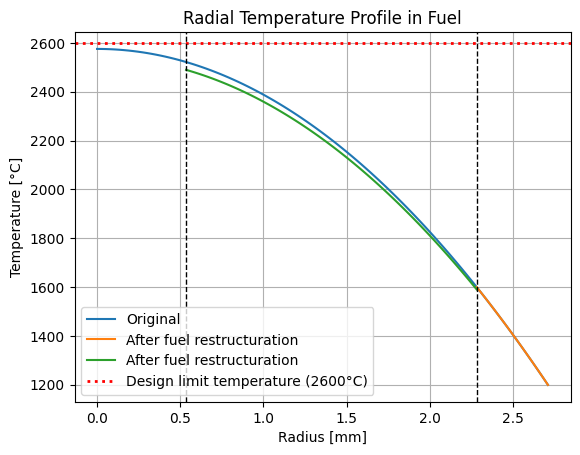

In [24]:
# Radius of different regions inside the fuel

# Inputs
T_fuel_cg_limit = 1600 #[°C] Temperature threshold for the formation of columnar grains

# Radius of the columnar grain region
T_fuel_cg_res = minimize_scalar(lambda r_fuel: abs(T_fuel_K(r_fuel, z_hot, k_fuel_asbuilt_avg) - (T_fuel_cg_limit + 273.15)), bounds=(0, r_fuel_out_0), method='bounded')
r_fuel_cg = T_fuel_cg_res.x  #[mm] Radius of the columnar grain region
T_fuel_cg = T_fuel_K(r_fuel_cg, z_hot, k_fuel_asbuilt_avg) - 273.15  #[°C] Verification of temperature of the fuel
r_fuel_void = r_fuel_cg * p_asbuilt**(1/2) #[mm]
T_fuel_void = T_fuel_K(r_fuel_void, z_hot, k_fuel_asbuilt_avg) - 273.15  #[°C] Verification of temperature of the fuel

# Updating radial temperature profile of the fuel in the as fabricated region (r_fuel_cg - r_fuel_out_0)
p_asbuilt = 0.055
r_fuel_asbuilt_values = np.linspace(r_fuel_cg, r_fuel_out_0, 100)  # r_fuel is in mm
T_fuel_asbuilt_values = T_fuel_K(r_fuel_asbuilt_values, z_hot, k_fuel_asbuilt_avg) - 273.15 #[°C]

# Updating radial temperature profile of the fuel in the as columnar grain region (r_fuel_void - r_fuel_cg)
p_cg = 0
k_fuel_cg_0 = k_fuel(T_fuel_cg + 273.15, x_dev_0, w_Pu_0, p_cg, beta_avg) #[W/m-K]
k_fuel_void_0 = k_fuel(T_fuel_void + 273.15, x_dev_0, w_Pu_0, p_cg, beta_avg) #[W/m-K]
k_fuel_cg_avg = (k_fuel_void_0 + k_fuel_cg_0)/2 #[W/m-K]  # Initial guess
iteration = 0
eps = 1e-4  # Convergence tolerance
max_iterations = 100  # To avoid infinite loops
print(f'Initial guess for the average thermal conductivity at the hottest axial position: {k_fuel_cg_avg:.2f} [W/m-K]')

while True:
    iteration += 1
    T_fuel_K_void = T_fuel_K(r_fuel_void, z_hot, k_fuel_cg_avg)
    k_fuel_void_0 = k_fuel(T_fuel_K_void, x_dev_0, w_Pu_0, p_cg, beta_avg)
    k_fuel_cg_avg_new = (k_fuel_void_0 + k_fuel_cg_0) / 2

    if abs(k_fuel_asbuilt_avg_new - k_fuel_asbuilt_avg) < eps or iteration >= max_iterations:
        k_fuel_cg_avg = k_fuel_cg_avg_new
        break

    k_fuel_cg_avg = k_fuel_cg_avg_new

if iteration >= max_iterations:
    print("Warning: Maximum iterations reached without convergence")
print(f'Average thermal conductivity at the hottest axial position: {k_fuel_cg_avg:.2f} [W/m-K]')

# Define the range of r_fuel values (from 0 to r_fuel_ext, in mm)
r_fuel_cg_values = np.linspace(r_fuel_void, r_fuel_cg, 100)  # r_fuel is in mm
T_fuel_cg_values = T_fuel_K(r_fuel_cg_values, z_hot, k_fuel_cg_avg) - 273.15 #[°C]
T_fuel_cg = T_fuel_K(r_fuel_cg, z_hot, k_fuel_cg_avg) - 273.15  #[°C] Verification of temperature of the fuel

# Verify temperature at the columnar grain boundary
print(f'Maximum temperature at fuel: {T_fuel_cg:.2f} [°C]')

# Print results
print(f'Radius of the columnar grain region: {r_fuel_cg:.2f} [mm]')
print(f'Temperature of the fuel at the radius of the columnar grain region: {T_fuel_cg:.2f} [°C]')
print(f'Radius of the void: {r_fuel_void:.2f} [mm]')
print(f'Temperature of the fuel at the radius of void: {T_fuel_void:.2f} [°C]')

# Plot the results
plt.plot(r_fuel_values_BOL, T_fuel_hot_values, label = 'Original')  # r_fuel is already in mm
plt.plot(r_fuel_asbuilt_values, T_fuel_asbuilt_values, label = 'After fuel restructuration')  # r_fuel is already in mm
plt.plot(r_fuel_cg_values, T_fuel_cg_values, label = 'After fuel restructuration')  # r_fuel is already in mm
plt.title('Radial Temperature Profile in Fuel')
plt.xlabel('Radius [mm]')
plt.ylabel('Temperature [°C]')
plt.axhline(T_fuel_limit, color = 'red', linestyle = ':', linewidth = 2, label ='Design limit temperature (2600°C)')
plt.axvline(r_fuel_void, color='black',linewidth=1.0, ls='--')
plt.axvline(r_fuel_cg, color='black',linewidth=1.0, ls='--')
plt.legend()
plt.grid()
plt.show()

## Plutonium redistribution (EOL Analysis)

Plutonium concentration at void radius: 0.32 [%wt]
Uranium concentration at void radius: 0.68 [%wt]


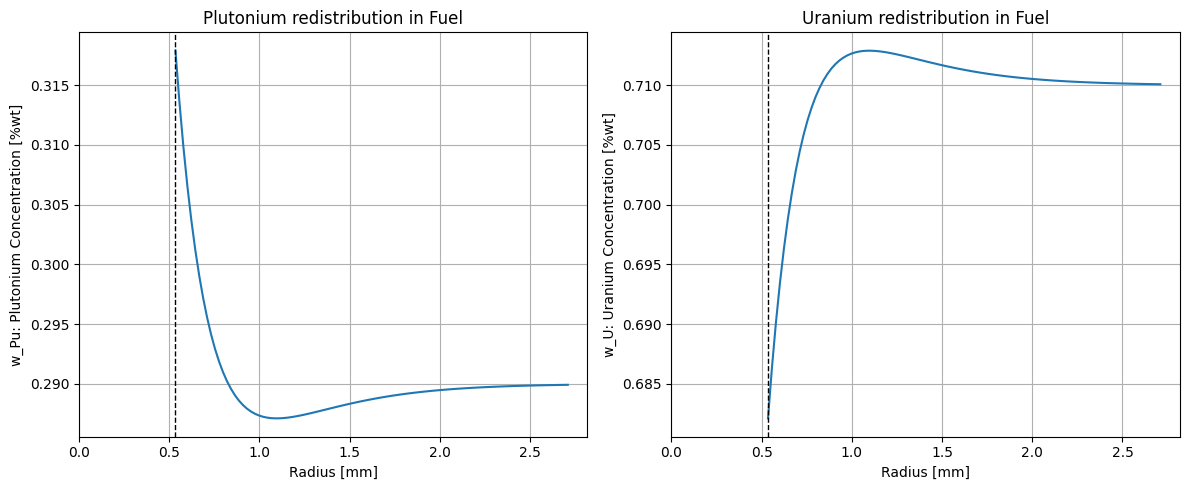

In [25]:
# Plutonium redistribution (and Uranium)

# Inputs
alpha = 7
D = 0.01
r_fuel_star = 0.207 * r_fuel_out_0

def w_Pu(r_fuel):
  r_norm = (r_fuel - r_fuel_void - r_fuel_star) / r_fuel_out_0
  return w_Pu_0 * (1 + D * (np.exp(-2 * alpha * r_norm) - 2 * np.exp(-alpha * r_norm))) #[%wt] Composition of Pu in the fuel

def w_U(r_fuel):
  r_norm = (r_fuel - r_fuel_void - r_fuel_star) / r_fuel_out_0
  return 1 - w_Pu_0 * (1 + D * (np.exp(-2 * alpha * r_norm) - 2 * np.exp(-alpha * r_norm))) #[%wt] Composition of U in the fuel

w_Pu_r0 = w_Pu(r_fuel_void)
w_U_r0 = w_U(r_fuel_void)

print(f'Plutonium concentration at void radius: {w_Pu_r0:.2f} [%wt]')
print(f'Uranium concentration at void radius: {w_U_r0:.2f} [%wt]')

r_fuel_values_EOL = np.linspace(r_fuel_void, r_fuel_out_0, 100)  # r_fuel is in mm
w_Pu_values = w_Pu(r_fuel_values_EOL) #[%wt] Composition of Pu in center of the fuel
w_U_values = w_U(r_fuel_values_EOL) #[%wt] Composition of Pu in center of the fuel

# Create a figure with two subplots arranged in 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
(ax1, ax2) = axs

ax1.plot(r_fuel_values_EOL, w_Pu_values)
ax1.set_title('Plutonium redistribution in Fuel')
ax1.set_xlabel('Radius [mm]')
ax1.set_ylabel('w_Pu: Plutonium Concentration [%wt]')
ax1.set_xlim(left=0)
ax1.axvline(r_fuel_void, color='black',linewidth=1.0, ls='--')
ax1.grid()

ax2.plot(r_fuel_values_EOL, w_U_values)
ax2.set_title('Uranium redistribution in Fuel')
ax2.set_xlabel('Radius [mm]')
ax2.set_ylabel('w_U: Uranium Concentration [%wt]')
ax2.set_xlim(left=0)
ax2.axvline(r_fuel_void, color='black',linewidth=1.0, ls='--')
ax2.grid()

plt.tight_layout()
plt.show()

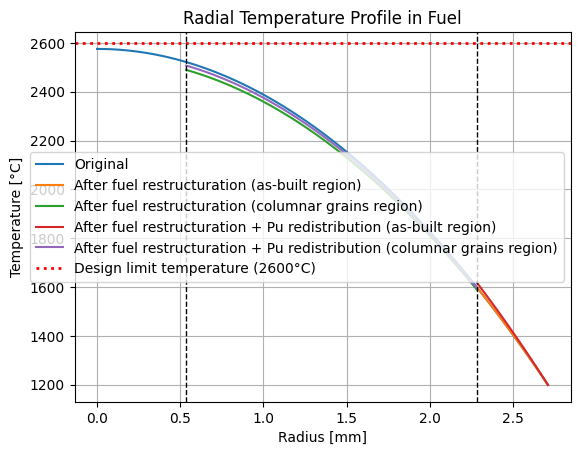

In [26]:
# RADIAL TEMPERATURE PROFILE OF FUEL AFTER FUEL RESTRUCTURING AND PU REDISTRIBUTION

# Fuel thermal conductivity (k_0) as a function of temperature and composition
def k_fuel_EOL(T_fuel_K, x_dev, r_fuel, p, t):
    A = 0.01926 + 1.06e-6*x_dev + 2.63e-8 * w_Pu(r_fuel)
    B = 2.39e-4 + 1.37e-13 * w_Pu(r_fuel)
    D = 5.27e9
    E = 17109.5
    k_fuel_0 = (1 / (A + B*T_fuel_K) + D / (T_fuel_K**2) * np.exp(-E / T_fuel_K)) * (1 - p)**2.5
    return 1.755 + (k_fuel_0 - 1.755) * np.exp(- beta5(r_fuel, t) / 128.75) #[W/m-K] Thermal conductivity of MOX fuel

# Define the temperature profile function
def T_fuel_K_EOL(r_fuel, z, k_fuel):
    C1 = (q_l(z) * 1e3 )/ (4 * np.pi * k_fuel) #[K]
    F_v = (1-(r_fuel/r_fuel_out_0)**2)
    return T_fuel_out_K_hot + C1 * F_v #[K] Radial temperature profile of fuel at hottest point at time 0

# Graphical estimation of new average conductivity for columnar grain and as-built grain regions
T_fuel_asbuilt_avg = T_fuel_asbuilt_values.mean()
k_fuel_asbuilt_EOL_avg = k_fuel_EOL(T_fuel_asbuilt_avg+273.15, x_dev_0, r_fuel_asbuilt_values, p_asbuilt, t_EOL).mean()
T_fuel_asbuilt_EOL_values = T_fuel_K(r_fuel_asbuilt_values, z_hot, k_fuel_asbuilt_EOL_avg) - 273.15 #[°C]

T_fuel_cg_avg = T_fuel_cg_values.mean()
k_fuel_cg_EOL_avg = k_fuel_EOL(T_fuel_cg_avg+273.15, x_dev_0, r_fuel_cg_values, p_cg, t_EOL).mean()
T_fuel_cg_EOL_values = T_fuel_K(r_fuel_cg_values, z_hot, k_fuel_cg_EOL_avg) - 273.15 #[°C]

# Plot the results
plt.plot(r_fuel_values_BOL, T_fuel_hot_values, label = 'Original')  # r_fuel is already in mm
plt.plot(r_fuel_asbuilt_values, T_fuel_asbuilt_values, label = 'After fuel restructuration (as-built region)')  # r_fuel is already in mm
plt.plot(r_fuel_cg_values, T_fuel_cg_values, label = 'After fuel restructuration (columnar grains region)')  # r_fuel is already in mm
plt.plot(r_fuel_asbuilt_values, T_fuel_asbuilt_EOL_values, label = 'After fuel restructuration + Pu redistribution (as-built region)')  # r_fuel is already in mm
plt.plot(r_fuel_cg_values, T_fuel_cg_EOL_values, label = 'After fuel restructuration + Pu redistribution (columnar grains region)')  # r_fuel is already in mm
plt.title('Radial Temperature Profile in Fuel')
plt.xlabel('Radius [mm]')
plt.ylabel('Temperature [°C]')
plt.axhline(T_fuel_limit, color = 'red', linestyle = ':', linewidth = 2, label ='Design limit temperature (2600°C)')
plt.axvline(r_fuel_void, color='black',linewidth=1.0, ls='--')
plt.axvline(r_fuel_cg, color='black',linewidth=1.0, ls='--')
plt.legend()
plt.grid()
plt.show()

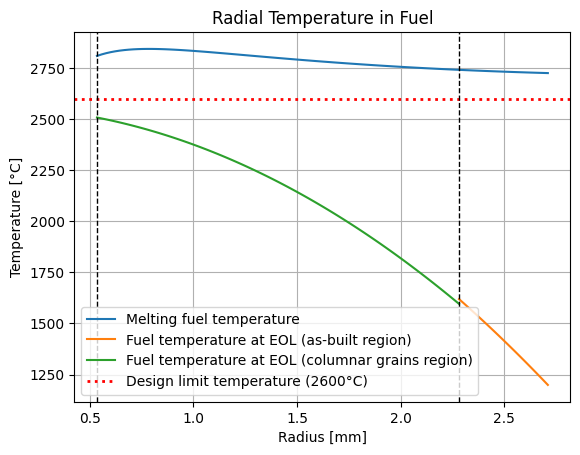

In [27]:
# Margin to melting of the fuel

def T_fuel_melt(r_fuel, t):
  beta = - beta5(r_fuel, t)
  return 2964.92 + ((3147 - 364.85 * w_Pu(r_fuel) - 1014.15 * x_dev_0) - 2964.92) * np.exp(- beta/41.01) - 273.15 #[°C]

T_fuel_melt_EOL_values = T_fuel_melt(r_fuel_values_EOL, t_EOL)

# Plot the results
plt.plot(r_fuel_values_EOL, T_fuel_melt_EOL_values, label = 'Melting fuel temperature')  # r_fuel is already in mm
plt.plot(r_fuel_asbuilt_values, T_fuel_asbuilt_EOL_values, label = 'Fuel temperature at EOL (as-built region)')  # r_fuel is already in mm
plt.plot(r_fuel_cg_values, T_fuel_cg_EOL_values, label = 'Fuel temperature at EOL (columnar grains region)')  # r_fuel is already in mm
plt.title('Radial Temperature in Fuel')
plt.xlabel('Radius [mm]')
plt.ylabel('Temperature [°C]')
plt.axhline(T_fuel_limit, color = 'red', linestyle = ':', linewidth = 2, label ='Design limit temperature (2600°C)')
plt.axvline(r_fuel_void, color='black',linewidth=1.0, ls='--')
plt.axvline(r_fuel_cg, color='black',linewidth=1.0, ls='--')
plt.legend()
plt.grid()
plt.show()

Fraction of fission gas release by the inner surface after EOL: 1.00
Fraction of fission gas release by the outer surface after EOL: 0.18
Average fraction of fission gas release by the open faces of the fuel at EOL: 0.31


(0.0, 1.0, 0.0, 1.0)

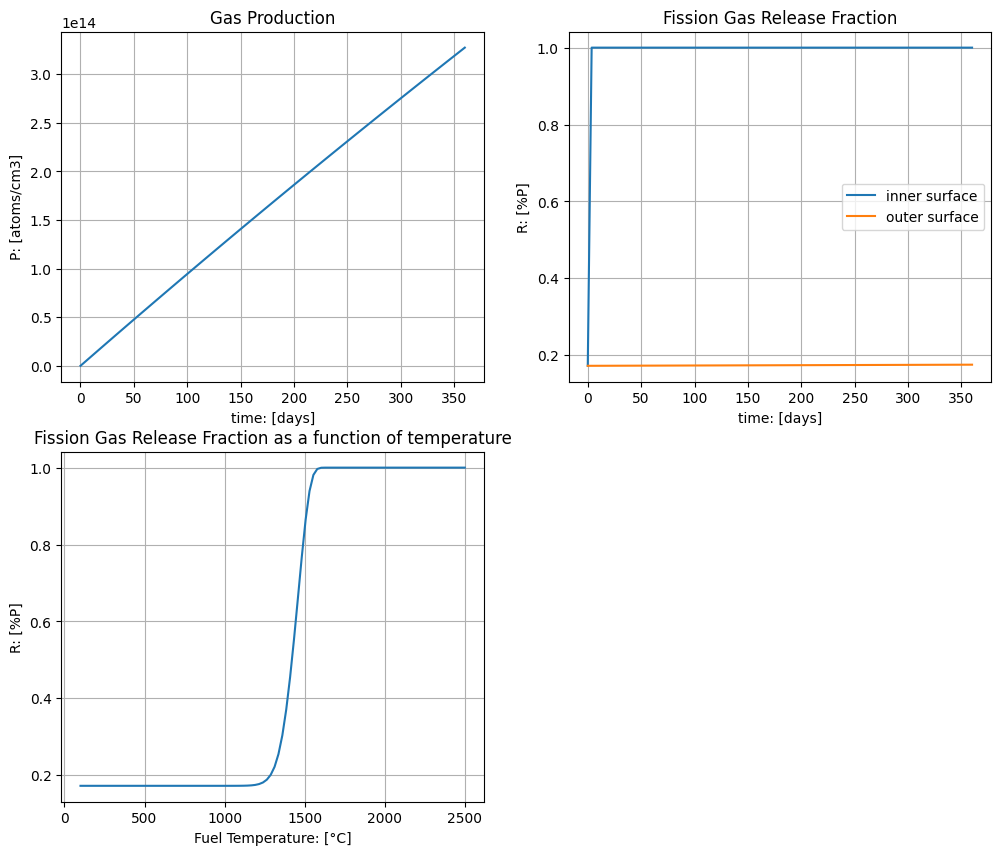

In [29]:
# Fission Gas Production

def instant_fission_rate(r_fuel, t):
    Sigma_tot_f = (N_U235(r_fuel, t) * sigma_U235_nf + N_U238(r_fuel, t) * sigma_U238_nf + N_Pu239(r_fuel, t) * sigma_Pu239_nf
                  + N_Pu240(r_fuel, t) * sigma_Pu240_nf + N_Pu241(r_fuel, t) * sigma_Pu241_nf) * 1e-24  #[cm^-1]
    return  phi_BOL(r_fuel) * Sigma_tot_f #[fissions/cm^3-s] Total number of fission events

def total_fission_events(r_fuel, t):
    N_U235_avg_int = N_U235_0 * (1 - np.exp(-sigma_U235_na * 1e-24 * phi_BOL(r_fuel) * t)) #[atoms/cm^3]
    N_U238_avg_int = N_U238_0 * (1 - np.exp(-sigma_U238_na * 1e-24 * phi_BOL(r_fuel) * t)) #[atoms/cm^3]
    C_Pu_239 = N_U238_0 * sigma_U238_ng / (sigma_Pu239_na - sigma_U238_ng) #[atoms/cm^3]
    N_Pu239_avg_int = (N_Pu239_0 - C_Pu_239) * (1 - np.exp(-sigma_Pu239_na * 1e-24 * phi_BOL(r_fuel) * t)) + C_Pu_239 * sigma_Pu239_na / sigma_U238_na * (1 - np.exp(-sigma_U238_na * 1e-24 * phi_BOL(r_fuel) * t))
    C_Pu_240 = N_Pu239_0 * sigma_Pu239_ng / (sigma_Pu240_na - sigma_Pu239_ng) #[atoms/cm^3]
    N_Pu240_avg_int = (N_Pu240_0 - C_Pu_240) * (1 - np.exp(-sigma_Pu240_na * 1e-24 * phi_BOL(r_fuel) * t)) + C_Pu_240 * sigma_Pu240_na / sigma_Pu239_na * (1 - np.exp(-sigma_Pu239_na * 1e-24 * phi_BOL(r_fuel) * t))
    C_Pu_241 = N_Pu240_0 * sigma_Pu240_ng / (sigma_Pu241_na - sigma_Pu240_ng) #[atoms/cm^3]
    N_Pu241_avg_int = (N_Pu241_0 - C_Pu_241) * (1 - np.exp(-sigma_Pu241_na * 1e-24 * phi_BOL(r_fuel) * t)) + C_Pu_241 * sigma_Pu241_na / sigma_Pu240_na * (1 - np.exp(-sigma_Pu240_na * 1e-24 * phi_BOL(r_fuel) * t))
    return N_U235_avg_int + N_U238_avg_int + N_Pu239_avg_int + N_Pu240_avg_int + N_Pu241_avg_int #[fissions/cm^3] Total number of fission events

def Gas_prod(y, t):
    F_avg = total_fission_events(r_fuel_avg, t) #[fissions/cm^3]
    return F_avg * y * 1e-6 #[atoms/m3]

def FGR_fraction(T_fuel, t, r_grain):
    D_eff = 5e-8 * np.exp( -40262/ T_fuel) #[m2/s] Effective diffusion coefficient the fission gas in solution
    term_1 = 1 / 1**2 * np.exp(- 1**2 * np.pi**2 * D_eff * t / r_grain**2 )
    term_2 = 1 / 2**2 * np.exp(- 2**2 * np.pi**2 * D_eff * t / r_grain**2 )
    term_3 = 1 / 3**2 * np.exp(- 3**2 * np.pi**2 * D_eff * t / r_grain**2 )
    return 1 - 6/np.pi**2 * (term_1 + term_2 + term_3) #[/] fraction of fission gas release from the fuel

# Inputs
y_gas_yielding = 0.3
gas_prod_values = Gas_prod(y_gas_yielding, t_values)
r_grain = D_grain/2 #[m] Radius of the grain considered as a sphere

FGR_fraction_void_EOL = FGR_fraction(T_fuel_void, t_EOL, r_grain) #[/] fraction of fission gas release from the fuel
FGR_fraction_surface_EOL = FGR_fraction(T_fuel_out_K_hot-273.15, t_EOL, r_grain) #[/] fraction of fission gas release from the fuel

FGR_fraction_void_values = FGR_fraction(T_fuel_void, t_values, r_grain) #[/] fraction of fission gas release from the fuel
FGR_fraction_surface_values = FGR_fraction(T_fuel_out_K_hot-273.15, t_values, r_grain) #[/] fraction of fission gas release from the fuel
print(f'Fraction of fission gas release by the inner surface after EOL: {FGR_fraction_void_EOL:.2f}')
print(f'Fraction of fission gas release by the outer surface after EOL: {FGR_fraction_surface_EOL:.2f}')

A_inner = 2 * np.pi * r_fuel_void * 1
A_outer = 2 * np.pi * r_fuel_out_0 * 1
A_total = A_inner + A_outer
A_inner_fraction = A_inner / A_total
A_outer_fraction = A_outer / A_total
FGR_fraction_avg = FGR_fraction_void_EOL * A_inner_fraction + FGR_fraction_surface_EOL * A_outer_fraction
print(f'Average fraction of fission gas release by the open faces of the fuel at EOL: {FGR_fraction_avg:.2f}')

T_fuel_eval = np.linspace(100,2500,100)
FGR_fraction_eval = FGR_fraction(T_fuel_eval, t_EOL, r_grain) #[/] fraction of fission gas release from the fuel

# Create a figure with two subplots arranged in 1 row and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
(ax1, ax2), (ax3, ax4) = axs

ax1.plot(t_values/(24*3600), gas_prod_values)
ax1.set_title('Gas Production')
ax1.set_xlabel('time: [days]')
ax1.set_ylabel('P: [atoms/cm3]')
ax1.grid()

ax2.plot(t_values/(24*3600), FGR_fraction_void_values, label = 'inner surface')
ax2.plot(t_values/(24*3600), FGR_fraction_surface_values, label = 'outer surface')
ax2.set_title('Fission Gas Release Fraction')
ax2.set_xlabel('time: [days]')
ax2.set_ylabel('R: [%P]')
ax2.legend()
ax2.grid()

ax3.plot(T_fuel_eval, FGR_fraction_eval)
ax3.set_title('Fission Gas Release Fraction as a function of temperature')
ax3.set_xlabel('Fuel Temperature: [°C]')
ax3.set_ylabel('R: [%P]')
ax3.grid()

ax4.axis('off')  # Remove the fourth subplot (if unnecessary)


In [32]:
# Presure inside cladding at EOL

# Inputs begin of life of the cycle
D_clad_in_0 = 2 * r_clad_in #[mm] Inner radius of cladding as-built
D_fuel_out_0 = D_fuel_out #[mm] Outer radius of fuel as-built
D_void_BOL = 0 #[mm] Inner radius of void as-built
H_act_0 = H_act #[mm] Initial active height of fuel rod
H_plenum_0 = 1500 #[mm] Initial height of plenum
T_gas_0 = 20 #[°C]
R = 8.314 #[Pa-m^3/mol−K] Gas constant

# Inputs end of life of the cycle
D_clad_in_EOL = 1.05 * D_clad_in_0 #[mm] Inner radius of cladding as-built
D_fuel_out_EOL = 1.01 * D_fuel_out #[mm] Outer radius of fuel as-built
D_void_EOL = 2 * r_fuel_void #[mm] Inner radius of void as-built
H_act_EOL = 1.25 * H_act_0 #[mm]
H_plenum_EOL = H_plenum_0 - H_act_EOL #[mm] Initial height of plenum
T_gas_EOL = T_gap_hot_values.mean() #[°C]

def V_gas(D_clad_in, D_fuel_out, D_void, H_plenum, H_act):
    V_plenum = np.pi * (D_clad_in/(2*1000))**2 * (H_plenum/1000) #[m^3]
    V_gap = np.pi * ((D_clad_in/(2*1000))**2 - (D_fuel_out/(2*1000))**2) * (H_act/1000) #[m^3]
    V_void = np.pi * (D_void/(2*1000))**2 * (H_act/1000) #[m^3]
    V_gas = V_plenum + V_gap + V_void
    return V_gas #[m^3] Volume of gas inside the cladding

V_gas_BOL = V_gas(D_clad_in_0, D_fuel_out_0, D_void_BOL, H_plenum_0, H_act_0) #[m^3]
V_gas_EOL = V_gas(D_clad_in_EOL, D_fuel_out_EOL, D_void_EOL, H_plenum_EOL, H_act_EOL) #[m^3]

n_He_0 = (P_gas_0 * 1e6 * V_gas_BOL)/ (R * (T_gas_0 + 273.15)) #[mol]
N_He_0 = n_He_0 * 6.022e23 / V_gas_BOL #[atoms/m^3]
N_FGR_EOL = 0.7 * Gas_prod(y_gas_yielding, t_EOL) #[atoms/m^3]
N_X_EOL = N_FGR_EOL #[atoms/m^3]

def P_gas(N_He, N_FGR, N_X, T_gas, V_gas_BOL, V_gas_EOL):
    N_He_EOL = N_He * V_gas_BOL / V_gas_EOL
    P_He = (N_He / 6.022e23) * R * (T_gas + 273.15) #[Pa]
    P_FGR = (N_FGR / 6.022e23) * R * (T_gas + 273.15) #[Pa]
    P_X = (N_X / 6.022e23) * R * (T_gas + 273.15) #[Pa]
    return (P_He + P_FGR + P_X) * 1e-6 #[MPa]

P_gas_EOL = P_gas(N_He_0, N_FGR_EOL, N_X_EOL, T_gas_EOL, V_gas_BOL, V_gas_EOL)

print(f'Initial atomic concentration of Helium: {N_He_0:.4e} [atoms/m^3]')
print(f'Pressure inside of cladding at the End-of-Life: {P_gas_EOL:.4f} [MPa]')

Initial atomic concentration of Helium: 2.4708e+25 [atoms/m^3]
Pressure inside of cladding at the End-of-Life: 0.3985 [MPa]


In [ ]:
# Cladding embrittlement

# Initial cladding composition

w_Cr_0 = 0.15 #[/] Initial mass fraction of Chrome
w_Ni_0 = 0.15 #[/] Initial mass fraction of Nickel
w_Mo_0 = 0.015 #[/] Initial mass fraction of Molybdenum
w_Mn_0 = 0.015 #[/] Initial mass fraction of Manganesum
w_Si_0 = 0.009 #[/] Initial mass fraction of Silicon
w_Ti_0 = 0.004 #[/] Initial mass fraction of Titanium
w_C_0 = 0.0009 #[/] Initial mass fraction of Carbon
w_B_0 = 60e-6 #[/] Initial mass fraction of Boron



## Radial Thermal Expansion

The thermal expansion coefficient for the cladding is given as:

$$ \varepsilon_{\text{th}} = -3.101 \cdot 10^{-4} + 1.545 \cdot 10^{-5} T(^{\circ}\mathrm{C}) + 2.75 \cdot 10^{-9} T(^{\circ}\mathrm{C})^2$$

While for the fuel it is given as:

$$\alpha_L = 1.2 \cdot 10^{-5} \, ^{\circ}\mathrm{C}^{-1}$$
at 25 degrees Celsius which will be taken as a reference temperature in further calculations.

Now we need to decide which initial temperatures to use and found that using the mean temperatures that correspond to the temperature profile of the hottest point (for the fuel and cladding) prove to be good initial gusesses.

After calcluating the thermal expansion coefficients, we need to calculate the radial expansion of the fuel and of the cladding. Both the fuel and the cladding expand outwards but due to different temperatures, the gap between them decreases, and the thickness of the cladding increases.

To find the new radii of the fuel, inner cladding we use:
$$
r_{\text{new}} = r_{\text{old}} \cdot \left( 1 + \alpha \cdot \Delta T \right)
$$


Here we need to be mindful because the cladding thermal expansion coeffficient already takes into account the temperature. So in our code, when calling the fucntion for the calculation of the new radius of the cladding, we set ΔT=1, while for the fuel it is equal to the temperature difference between the mean temperature and the reference one.

After finding the new radii, we need to find the temperature profiles again, and that part is done the same as before.

After itterating until convergence, we notice that the gap between the fuel and the inner wall of the cladding decreases, but is still bigger than 0.


In [ ]:
# Radial Thermal Expansion

# Step 1: Mean Temperature Calculation
def calculate_mean_temperature(temperature_profile):
    return np.mean(temperature_profile)

# Step 2: Cladding Expansion Coefficient
def cladding_expansion_coefficient(T):
    return -3.101e-4 + 1.545e-5 * T + 2.75e-9 * T**2

# Step 3: Apply Thermal Expansion
def apply_thermal_expansion(radius, expansion_coefficient, delta_T):
    return radius * (1 + expansion_coefficient * delta_T)

# Fuel Thermal Conductivity Function
def k_fuel(T_fuel_K, x_dev, x_Pu, p, beta):
    A = 0.01926 + 1.06e-6 * x_dev + 2.63e-8 * x_Pu
    B = 2.39e-4 + 1.37e-13 * x_Pu
    D = 5.27e9
    E = 17109.5
    k_fuel_0 = (1 / (A + B * T_fuel_K) + D / (T_fuel_K**2) * np.exp(-E / T_fuel_K)) * (1 - p)**2.5
    return 1.755 + (k_fuel_0 - 1.755) * np.exp(-beta / 128.75)

# Fuel Temperature Profile
def T_fuel_K(r_fuel, z, k_fuel, T_fuel_out_K_hot, r_fuel_out_0, q_l):
    C1 = (q_l * 1e3) / (4 * np.pi * k_fuel)
    F_v = 1 - (r_fuel / r_fuel_out_0)**2
    return T_fuel_out_K_hot + C1 * F_v

# Cladding Thermal Conductivity Function
def k_clad(T_clad):
    return 13.95 + 0.01163 * T_clad

# Cladding Temperature Profile
def T_clad_r0(r_clad, k_clad, q_l0, T_clad_out0, r_clad_out):
    C = T_clad_out0 + (q_l0 * 1e3 * np.log(r_clad_out)) / (2 * np.pi * k_clad)
    return -(q_l0 * 1e3 * np.log(r_clad)) / (2 * np.pi * k_clad) + C

# Gap Thermal Conductivity Function
def k_He(T_gap):
    return 15.8e-4 * T_gap**0.79

# Gap Temperature Profile
def T_gap_K_0(r_gap, k_He, q_l0, T_gap_out0_K, r_gap_out):
    C = T_gap_out0_K + (q_l0 * 1e3 * np.log(r_gap_out)) / (2 * np.pi * k_He)
    return -(q_l0 * 1e3 * np.log(r_gap)) / (2 * np.pi * k_He) + C

# Iterative Thermal Expansion Function
def iterate_thermal_expansion(fuel_radius, cladding_inner_radius, cladding_outer_radius,
                              fuel_temp_profile, cladding_temp_profile,
                              q_l, z_hot, T_fuel_out_K_hot, x_dev_0, x_Pu_0, p_asbuilt, beta_avg,
                              T_clad_out0, r_clad_out, r_fuel_out_0, max_iterations=10, tolerance=1e-4):

    iteration = 0
    converged = False


    while iteration < max_iterations and not converged:
        # Step 1: Calculate mean temperatures
        mean_fuel_temp = calculate_mean_temperature(fuel_temp_profile)
        mean_cladding_temp = calculate_mean_temperature(cladding_temp_profile)

        # Step 2: Calculate thermal expansion coefficients
        expansion_coef_fuel = 1.2e-5  # Fuel expansion coefficient (constant)
        expansion_coef_cladding = cladding_expansion_coefficient(mean_cladding_temp)
        deltaT = mean_fuel_temp - 25

        # Step 3: Update radii
        new_fuel_radius = apply_thermal_expansion(fuel_radius, expansion_coef_fuel, deltaT)
        new_cladding_inner_radius = apply_thermal_expansion(cladding_inner_radius, expansion_coef_cladding, 1)
        new_cladding_outer_radius = apply_thermal_expansion(cladding_outer_radius, expansion_coef_cladding, 1)



        # Step 4: Recalculate cladding thickness
        new_cladding_thickness = new_cladding_outer_radius - new_cladding_inner_radius

        # Step 5: Recalculate temperature profiles

        # Fuel Temperature Profile Calculation
        k_fuel_avg = k_fuel(T_fuel_out_K_hot, x_dev_0, x_Pu_0, p_asbuilt, beta_avg)
        r_fuel_values = np.linspace(0, new_fuel_radius, 100)
        fuel_temp_profile = T_fuel_K(r_fuel_values, z_hot, k_fuel_avg, T_fuel_out_K_hot, new_fuel_radius, q_l) - 273.15

        # Cladding Temperature Profile Calculation
        k_clad_avg = k_clad(T_clad_out0)
        r_clad_values = np.linspace(new_cladding_inner_radius, new_cladding_outer_radius, 100)
        cladding_temp_profile = T_clad_r0(r_clad_values, k_clad_avg, q_l, T_clad_out0, new_cladding_outer_radius)

        # Check for convergence (based on change in mean temperatures)
        new_mean_fuel_temp = calculate_mean_temperature(fuel_temp_profile)
        new_mean_cladding_temp = calculate_mean_temperature(cladding_temp_profile)

        if (abs(new_mean_fuel_temp - mean_fuel_temp) < tolerance) and (abs(new_mean_cladding_temp - mean_cladding_temp) < tolerance):
            converged = True

        iteration += 1

    if converged:
        print("Convergence achieved!")
    else:
        print("Maximum iterations reached without convergence.")

    return new_fuel_radius, new_cladding_inner_radius, new_cladding_outer_radius

# Example Initial Inputs
fuel_radius = r_fuel_out_0  # Initial fuel radius in meters
cladding_inner_radius = r_clad_in  # Initial cladding inner radius in meters
cladding_outer_radius = r_clad_out  # Initial cladding outer radius in meters
q_l = q_l0  # Linear heat generation rate
z_hot = z_hot  # Axial coordinate of the hottest point
T_fuel_out_K_hot = T_gap_in_hot_C + 273.15  # Outer fuel temperature in Kelvin
x_dev_0 = 2 - OM_ratio_0
x_Pu_0 = 0.29
p_asbuilt = 0.055
beta_avg = beta_avg
T_clad_out0 = T_clad_out0  # Outer cladding temperature
r_clad_out = r_clad_out
r_fuel_out_0 = r_fuel_out_0
t_clad_i0 = t_clad_i0
gap_initial = r_clad_in - r_fuel_out_0

# Example Temperature Profiles
fuel_temp_profile = T_fuel_hot_values  # In °C
cladding_temp_profile = T_clad_hot_values  # In °C

# Execute the Function
final_fuel_radius, final_clad_inner_radius, final_clad_outer_radius = iterate_thermal_expansion(
    fuel_radius, cladding_inner_radius, cladding_outer_radius,
    fuel_temp_profile, cladding_temp_profile,
    q_l, z_hot, T_fuel_out_K_hot, x_dev_0, x_Pu_0, p_asbuilt, beta_avg,
    T_clad_out0, r_clad_out, r_fuel_out_0
)

final_clad_thickness = final_clad_outer_radius - final_clad_inner_radius
final_gap = final_clad_inner_radius - final_fuel_radius

# Calculate percentage increases
fuel_radius_increase = ((final_fuel_radius - r_fuel_out_0) / r_fuel_out_0) * 100
clad_inner_radius_increase = ((final_clad_inner_radius - r_clad_in) / r_clad_in) * 100
clad_outer_radius_increase = ((final_clad_outer_radius - r_clad_out) / r_clad_out) * 100
clad_thickness_increase = ((final_clad_thickness - t_clad_i0) / t_clad_i0) * 100
gap_increase = ((final_gap - gap_initial) / gap_initial) * 100

# Print initial and final values with percentage increases
print(f"Initial Fuel Radius: {r_fuel_out_0:.6f} mm")
print(f"Final Fuel Radius: {final_fuel_radius:.6f} mm")
print(f"Fuel Radius Increase: {fuel_radius_increase:.2f}%\n")

print(f"Initial Cladding Inner Radius: {r_clad_in:.6f} mm")
print(f"Final Cladding Inner Radius: {final_clad_inner_radius:.6f} mm")
print(f"Cladding Inner Radius Increase: {clad_inner_radius_increase:.2f}%\n")

print(f"Initial Cladding Outer Radius: {r_clad_out:.6f} mm")
print(f"Final Cladding Outer Radius: {final_clad_outer_radius:.6f} mm")
print(f"Cladding Outer Radius Increase: {clad_outer_radius_increase:.2f}%\n")

print(f"Initial Cladding Thickness: {t_clad_i0:.6f} mm")
print(f"Final Cladding Thickness: {final_clad_thickness:.6f} mm")
print(f"Cladding Thickness Increase: {clad_thickness_increase:.2f}%\n")

print(f"Initial Gap: {gap_initial:.6f} mm")
print(f"Final Gap: {final_gap:.6f} mm")
print(f"Gap Percentage Decrease: {gap_increase:.2f}%")


## Calculation of the yielding of the cladding.

We can get the answer of the stress, and obviously the yield strength of the cladding is much lower than the limitation.

Sigma not thin wall case is : 1.407334211682038 [MPa]

Sigma thin wall case is : 1.041666666666667 [MPa]

Sigma longitudinal stress is : 0.5208333333333335 [MPa]

Sigma thin wall case is : 0.5208333333333335 [MPa]

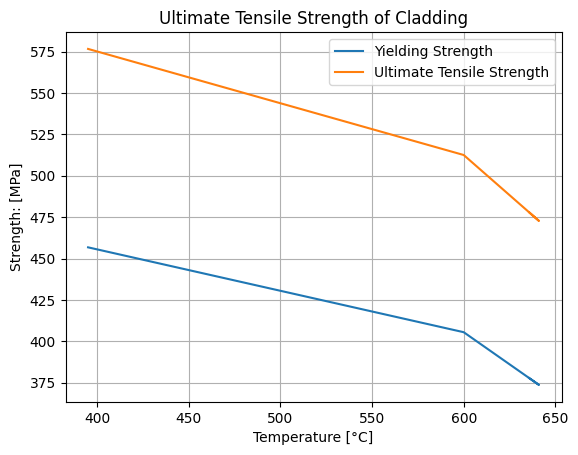

Hoop stress (non-thin-wall case): 0.681 [MPa]
Hoop stress (thin-wall case): 0.628 [MPa]
sigma longitudinal stress is : 0.3138888888888889 [MPa]
sigma longitudinal stress is : 0.34073315118397074 [MPa]
sigma thin wall case is : 0.3138888888888889 [MPa]
sigma not thin wall case is : 0.3675774134790526 [MPa]
Epsilon_th at outer cladding: 0.008647 at 529.8113748849335°C
Epsilon_th at inner cladding: 0.009474 574.5012129773252°C


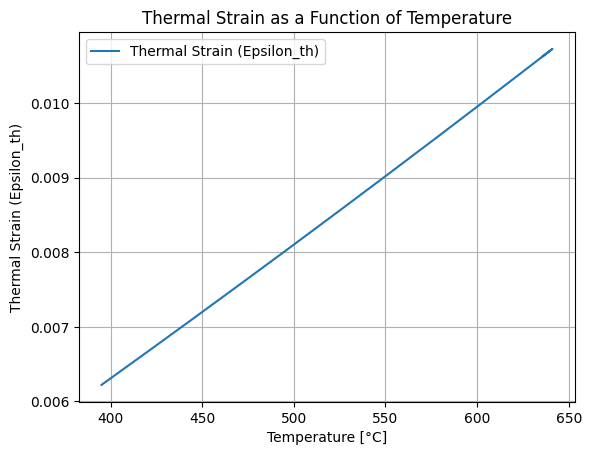

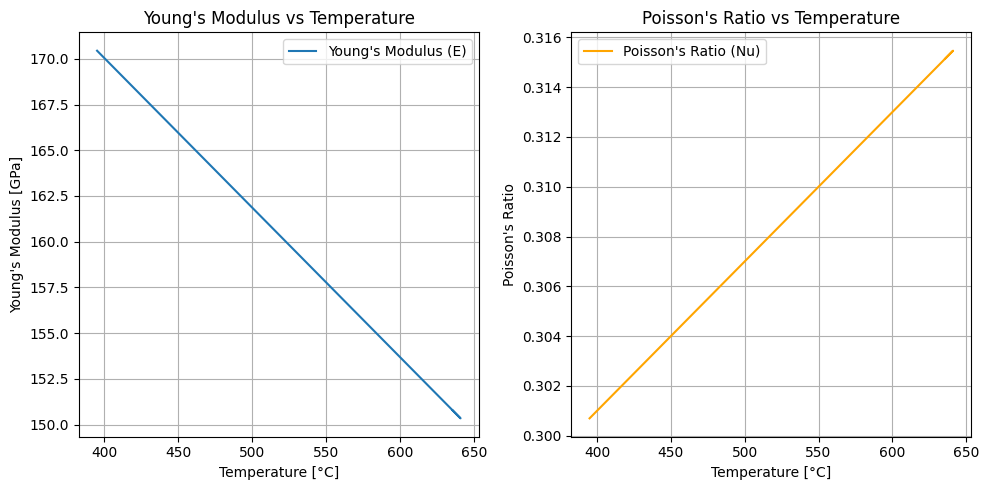

NameError: name 'epsilon_th_clad' is not defined

In [36]:
#Cladding yielding

# Inputs
t_clad_i0 = 0.45 #[mm] Initial guess of cladding thickness
r_clad_mw0 = r_clad_mw #[mm] cladding center diameter
T_clad_mw_values = T_clad(r_clad_mw, k_clad_avg, z_values)

# Cladding yielding strength (sigma_Y) as a function of temperature
def Sigma_Y_clad(T_clad):
    return np.where(T_clad < 600,
        555.5 - 0.25 * T_clad,                 # Equation for T < 600°C
        405.5 - 0.775 * (T_clad - 600))        # For 600°C ≤ T < 1000°C. Optional: Define behavior for T ≥ 1000°

# Cladding ultimate tensile strength (UTS) as a function of temperature
def UTS_clad(T_clad):
    return np.where(T_clad < 600,
        700 - 0.3125 * T_clad,                    # For T < 600°C
        512.5 - 0.969 * (T_clad - 600))           # For 600°C ≤ T < 1000°C. Optional: Define behavior for T ≥ 1000°

# Evaluation of strength for all temperatures
sigmaY_clad_values = Sigma_Y_clad(T_clad_mw_values)
UTS_clad_values = UTS_clad(T_clad_mw_values)

# Plot yielding strength and UTS
plt.plot(T_clad_mw_values, sigmaY_clad_values, label='Yielding Strength')
plt.plot(T_clad_mw_values, UTS_clad_values, label='Ultimate Tensile Strength')
plt.title('Ultimate Tensile Strength of Cladding')
plt.xlabel('Temperature [°C]')
plt.ylabel('Strength: [MPa]')
plt.grid()
plt.legend()
plt.show()

# Hoop stress for non-thin-wall case
sigma_n = P_gas_0 * (((D_clad_in_0 * 1e-3 / 2)**2) / (((D_clad_out * 1e-3 / 2)**2) - ((D_clad_in_0 * 1e-3 / 2)**2))) * (((D_clad_out * 1e-3 / 2)**2) / ((D_clad_in_0 * 1e-3 / 2)**2) + 1)  # This is for not thin wall case, cladding
sigma_n2 = sigma_n / 2

# Hoop stress for thin-wall case
sigma1 = P_gas_0 * (D_clad_in_0 * 1e-3  / 2) / (t_clad_i0/1000)
sigma2 = sigma1 / 2 #sigma2 is longitudinal stress

# Output results
print(f'Hoop stress (non-thin-wall case): {sigma_n:.3f} [MPa]')
print(f'Hoop stress (thin-wall case): {sigma1:.3f} [MPa]')
print(f'sigma longitudinal stress is : {sigma2} [MPa]')
print(f'sigma longitudinal stress is : {sigma_n2} [MPa]')

#In the verification, we use the tresca method
sigmaY_thinwall = sigma1 - sigma2
sigmaY_notthinwall = sigma_n - sigma2

print(f'sigma thin wall case is : {sigmaY_thinwall} [MPa]')
print(f'sigma not thin wall case is : {sigmaY_notthinwall} [MPa]')

# Absolutely, the sigmaY of the thin wall is much lower that the sigma yield, so it works
#And then we calculate the linear thermal expansion, because there are different tempurature of cladding inner and outer, so we need to get the average

# Define the epsilon_th function
def eps_th_clad(T_clad):
    return -3.101 * 10**-4 + (1.545 * 10**-5) * T_clad + 2.75 * 10**-9 * (T_clad**2)


# Evaluate epsilon_th at different points
eps_th_clad_out = eps_th_clad(T_clad_out0)  # Outer cladding
eps_th_clad_in = eps_th_clad(T_clad_in0)  # Inner cladding

# Print results
print(f"Epsilon_th at outer cladding: {eps_th_clad_out:.6f} at {T_clad_out0}°C")
print(f"Epsilon_th at inner cladding: {eps_th_clad_in:.6f} {T_clad_in0}°C")

# If needed, apply to an array of temperatures (e.g., to plot epsilon_th as a function of T)
eps_th_clad_mw_values = eps_th_clad(T_clad_mw_values)

# Plot thermal strain of the cladding
plt.plot(T_clad_mw_values, eps_th_clad_mw_values, label='Thermal Strain (Epsilon_th)')
plt.title('Thermal Strain as a Function of Temperature')
plt.xlabel('Temperature [°C]')
plt.ylabel('Thermal Strain (Epsilon_th)')
plt.grid()
plt.legend()
plt.show()

# Define functions for Young's modulus and Poisson's ratio
def E_clad(T_clad):
    return 202.7 - 0.08167 * T_clad

def Poisson_clad(T_clad):
    return 0.277 + 6 * 10**-5 * T_clad

# Evaluate over a temperature range
E_clad_values = E_clad(T_clad_mw_values)
Poisson_clad_values = Poisson_clad(T_clad_mw_values)

# Plot the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(T_clad_mw_values, E_clad_values, label="Young's Modulus (E)")
plt.title("Young's Modulus vs Temperature")
plt.xlabel("Temperature [°C]")
plt.ylabel("Young's Modulus [GPa]")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T_clad_mw_values, Poisson_clad_values, label="Poisson's Ratio (Nu)", color='orange')
plt.title("Poisson's Ratio vs Temperature")
plt.xlabel("Temperature [°C]")
plt.ylabel("Poisson's Ratio")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

#From linear thermal expansion to coefficient of thermal expansion
alpha_CTE_outer = epsilon_th_clad /  (H_act * 1e-3 * (T_clad_mw_0 - T_clad_out0))
alpha_CTE_inner = epsilon_th_clad /  (H_act * 1e-3 * (T_clad_in0 - T_clad_mw_0))

print(f'coefficient of thermal expansion from cladding average tempurature to outer tempurature : {alpha_CTE_outer} [per DegC]')
print(f"coefficient of thermal expansion from cladding inner to the middle : {alpha_CTE_inner} [per DegC]")

#Thermal stress
sigma_th_outer = ((alpha_CTE_outer * E )/ ((1 - Nu) )* (Tc_average - Tcot))
sigma_th_inner = ((alpha_CTE_inner * E )/ ((1 - Nu) )* (Tc_average - Tcit))
print(f"thermal stress outer part of cladding: {sigma_th_outer} [MPa]")
print(f"thermal stress inner part of cladding: {sigma_th_inner} [MPa]")

We can get the answer of the stress, and obviously the
Sigma not thin wall case is : 1.407334211682038 [MPa]
Sigma thin wall case is : 1.041666666666667 [MPa]
Sigma longitudinal stress is : 0.5208333333333335 [MPa]
Sigma thin wall case is : 0.5208333333333335 [MPa]

In [ ]:
# Function of burnup as a function of the composition

def beta3(rho_fuel, r_fuel, H_fuel, w_U235, w_U238, w_Pu, time):
    V_fuel = np.pi* r_fuel_out_0 **2 *H_fuel * 1e-9 #[m^3] Reference volume of fuel
    m_fuel = rho_fuel * V_fuel/1000 #[ton-MOx] Weight of fuel material per fuel rod
    x_U235 = (w_U235/M_U235) / ((w_U235/M_U235) + (w_U238/M_U238)) #[/] Molar fraction of U-235 in natural Uranium
    x_U238 = 1 - x_U235  #[/] Molar fraction of U-238 in natural Uranium
    M_U = x_U235*M_U235 + x_U238*M_U238 #[g/gmol] Molar mass of Uranium
    w_U = 1 - w_Pu #[/] Mass fraction of U in MOX
    x_Pu = (w_Pu/M_Pu) / ((w_Pu/M_Pu) + (w_U/M_U)) #[/] Molar fraction of Pu in MOX
    x_U = 1 - x_Pu #[/] Molar fraction of U in MOX
    M_HM = x_Pu*M_Pu + x_U*M_U  #[g/gmol] Molar mass of Heavy Metal
    n_HM = m_fuel / (M_HM + OM_ratio_0 * M_O)  #[ton-mol] Moles of Heavy Metal in MOX
    n_O = OM_ratio_0 * n_HM #[ton-mol] Numero de moles de Oxygen
    m_HM = n_HM * M_HM #[ton_HM] Toneladas de Heavy Metal
    N_U235 = x_U235 * (n_HM * x_U) * 6.022e23 / V_fuel  #[atoms/cm^3]
    N_U238 = x_U238 * (n_HM * x_U) * 6.022e23 / V_fuel #[atoms/cm^3]
    N_Pu = n_HM * x_Pu * 6.022e23 / V_fuel #[atoms/cm^3]
    Fission_rate = phi_BOL(r_fuel) * (N_U235 * sigma_U235_nf + N_U238 * sigma_U238_nf + N_Pu * sigma_Pu239_nf) * 1e-24 #[fissions/cm^3-s] Total number of fission events
    return  Fission_rate * (time * 24 * 3600) * 3.708E-25 / (rho_fuel / 1e9) #[GWd/t_HM]

# Average burnup of the fuel rod
rho_fuel_0 = 0.945*TD_fuel*1e3 #[kg/m^3] Fuel density %TD
r_fuel_out_0 = D_fuel_out/2 #[mm] Fuel pellet outer radius
H_fuel_0 = H_act
beta_avg = beta3(rho_fuel_0, r_fuel_out_0, H_fuel_0, w_U235_0, w_U238_0, w_Pu_0, t_cycle)
beta_values = beta3(rho_fuel_0, r_fuel_values, H_fuel_0, w_U235_0, w_U238_0, w_Pu_0, t_cycle)

plt.plot(r_fuel_values, beta_values)
plt.title('Radial distribution of burnup')
plt.xlabel('Radius [mm]')
plt.ylabel('Beta(r): Burnup [GWd/t-HM]')
plt.grid()
plt.show()

In [ ]:
# Neutron Flux as a function of the radius and composition

def phi(r_fuel, t):
  Sigma_tot_a = (N_U235_avg(r_fuel, t) * sigma_U235_na + N_U238_avg(r_fuel, t) * sigma_U238_na +  N_Pu239_avg(r_fuel, t) * sigma_Pu239_na
                + N_Pu240_avg(r_fuel, t) * sigma_Pu240_na + N_Pu241_avg(r_fuel, t) * sigma_Pu241_na) * 1e-24 #[cm^-1]
  N_tot_avg = N_U235_avg(r_fuel, t) + N_U238_avg(r_fuel, t) + N_Pu239_avg(r_fuel, t) + N_Pu240_avg(r_fuel, t) + N_Pu241_avg(r_fuel, t) #[atoms/cm^3]
  D = 1 / (3 * 1.764511 * 1e-24 * N_tot_avg) #[cm]
  kappa = (Sigma_tot_a / D)**0.5 #[cm^-1]
  return phi_0 * j0(kappa * (r_fuel/10)) #[n/cm^2-s] Neutron flux at peak power. Where j0 is the zeroth-order Bessel function

phi_values = phi(r_fuel_values_BOL, t_EOL)
phi_R_ext = phi(1.0, 0)
print(f'Neutron flux in extrapolated radius {phi_R_ext:.4e}')

plt.plot(r_fuel_values_BOL, phi_values)
plt.title('Radial distribution of neutron flux')
plt.xlabel('Radius [mm]')
plt.ylabel('phi(r): Neutron flux [n/cm^2/s]')
plt.grid()
plt.show()